In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2
#* magic to add python path to notebook environment
import sys
pypath = sys.path[0]
%env PYTHONPATH $pypath

from apps import cex_toy_generator, cex_toy_parameters
from IPython.display import clear_output
from python.analysis import cross_section, Plots
from scipy.stats import norm, lognorm
from statsmodels.stats.weightstats import ztest as ztest

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from rich import print
cross_section.SetPlotStyle(True, 80)

def CreateConfig(PDSP : int = 1, p_init : float = 1000, events : int = 50805, seed : int = None, verbose : bool = False, modified_PDFs : dict[np.array] = None, scale_factors : dict[float] = None):
    return {
    "events" : events,
    "step" : 2,
    "p_init" : p_init,
    "beam_profile" : "gaussian",
    "beam_width" : 60,

    "smearing_params" : {
        "KE_init" : f"/home/sb16165/Documents/pi0-analysis/analysis/work/2023/PDSPProd4a_MC_{PDSP}GeV_reco1_sce_datadriven_v1_ntuple_v09_41_00_03/toy_parameters/smearing/KE_ff_resolution.json",
        "KE_int" : f"/home/sb16165/Documents/pi0-analysis/analysis/work/2023/PDSPProd4a_MC_{PDSP}GeV_reco1_sce_datadriven_v1_ntuple_v09_41_00_03/toy_parameters/smearing/KE_int_resolution.json",
        "z_int" : f"/home/sb16165/Documents/pi0-analysis/analysis/work/2023/PDSPProd4a_MC_{PDSP}GeV_reco1_sce_datadriven_v1_ntuple_v09_41_00_03/toy_parameters/smearing/track_length_resolution.json"
    },
    "reco_region_fractions" : f"/home/sb16165/Documents/pi0-analysis/analysis/work/2023/PDSPProd4a_MC_{PDSP}GeV_reco1_sce_datadriven_v1_ntuple_v09_41_00_03/toy_parameters/reco_regions/reco_region_fractions.hdf5",
    "beam_selection_efficiencies" : f"/home/sb16165/Documents/pi0-analysis/analysis/work/2023/PDSPProd4a_MC_{PDSP}GeV_reco1_sce_datadriven_v1_ntuple_v09_41_00_03/toy_parameters/pi_beam_efficiency/beam_selection_efficiencies_true.hdf5",
    "mean_track_score_kde" : f"/home/sb16165/Documents/pi0-analysis/analysis/work/2023/PDSPProd4a_MC_{PDSP}GeV_reco1_sce_datadriven_v1_ntuple_v09_41_00_03/toy_parameters/meanTrackScoreKDE/kdes.dill",
    "pdf_scale_factors" : scale_factors,
    "verbose" : verbose,
    "seed" : seed,
    "modified_PDFs" : modified_PDFs
    }


# def CreateObservedInputData(toy : cross_section.Toy, energy_bins : np.array, mean_track_score_bins : np.array = None, alt_regions : pd.DataFrame = None):
#     toy_observed_binned = []

#     reco_regions = toy.df.filter(regex = "reco_regions") if alt_regions is None else alt_regions.columns 

#     for c in reco_regions:
#         m = toy.df[c] if alt_regions is None else alt_regions[c]
#         toy_observed_binned.append(np.histogram(toy.df.KE_int_smeared[m], bins = energy_bins)[0])
#     if mean_track_score_bins is not None:
#         toy_observed_binned.append(np.histogram(toy.df.mean_track_score[toy.df.inclusive_process != "decay"], mean_track_score_bins)[0])
#     return toy_observed_binned

# def CreateModelInputData(toy : cross_section.Toy, bins : np.array):
#     model_input_data = []
#     for c in toy.df.filter(regex = "reco_regions"):
#         tmp = []
#         for s in toy.df.filter(regex = "truth_regions"):
#             tmp.append(np.histogram(toy.df.KE_int_smeared[toy.df[c] & toy.df[s]], bins = bins)[0])
#         model_input_data.append(tmp)
#     return model_input_data

def SliceModelPrediction(prediction : cross_section.cabinetry.model_utils.ModelPrediction, slice : slice, label : str):
    return cross_section.cabinetry.model_utils.ModelPrediction(prediction.model, np.array(prediction.model_yields[slice]), np.array(prediction.total_stdev_model_bins[slice]), np.array(prediction.total_stdev_model_channels[slice]), label)


def RegionFitToyStudy(toy : cross_section.Toy, model : cross_section.pyhf.Model, energy_slice : cross_section.Slices, mean_track_score_bins : np.array = None, pdf : Plots.PlotBook = None):

    fit_input = cross_section.AnalysisInput.CreateAnalysisInputToy(toy)
    # if alt_regions is not None:
    #     fit_input.regions = alt_regions

    observed = cross_section.RegionFit.GenerateObservations(fit_input, energy_slice, mean_track_score_bins, model)
    result = cross_section.RegionFit.Fit(observed, model, False)

    postfit_pred = cross_section.cabinetry.model_utils.prediction(model, fit_results = result)

    #* split post fit results by the observables
    if mean_track_score_bins is not None:
        KE_int_prediction = SliceModelPrediction(postfit_pred, slice(-1), "KE_int_postfit")
        # mean_track_score_prediction = SliceModelPrediction(postfit_pred, slice(len(model.config.channels) - 1, len(model.config.channels)), "mean_track_score_postfit")
    else:
        KE_int_prediction = postfit_pred

    total_count_err = np.sum(np.power(KE_int_prediction.total_stdev_model_channels, 2))**0.5
    total_count = np.sum(KE_int_prediction.model_yields)
    # total_count_actual = np.sum(prefit_pred.model_yields)
    # total_count_actual = sum((toy.df.inclusive_process != "decay") & (toy.df.KE_int_smeared > min(energy_slice.pos)) & (toy.df.KE_int_smeared < max(energy_slice.pos)))

    # Plot fitted correlation matrix and actual
    plot = Plots.MultiPlot(2)
    next(plot)
    # truth_regions_masksed = {t : toy.truth_regions[t] & (((toy.df.KE_int_smeared) > min(energy_slice.pos)) & ((toy.df.KE_int_smeared) < max(energy_slice.pos))) for t in toy.truth_regions}
    # reco_regions_masksed = {r : toy.reco_regions[r] & (((toy.df.KE_int_smeared) > min(energy_slice.pos)) & ((toy.df.KE_int_smeared) < max(energy_slice.pos))) for r in toy.reco_regions} 
    # counts_matrix = cross_section.Toy.ComputeCounts(truth_regions_masksed, reco_regions_masksed)
    counts_matrix = []
    for j in toy.truth_region_labels:
        counts = []
        for i in toy.reco_region_labels:
            counts.append(sum(toy.NInteract(energy_slice, toy.truth_regions[j], toy.reco_regions[i])))
        counts_matrix.append(counts)
    print(f"{counts_matrix=}")
    total_count_actual = np.sum(counts_matrix)
    cex_toy_parameters.PlotCorrelationMatrix(counts_matrix, toy.truth_region_labels, toy.reco_region_labels, title = "actual", newFigure = False)
    next(plot)
    counts_matrix = []
    for c in KE_int_prediction.model_yields:
        counts_matrix.append([sum(s) for s in c])
    counts_matrix = np.array(counts_matrix, dtype = int).T
    cex_toy_parameters.PlotCorrelationMatrix(counts_matrix, toy.truth_region_labels, toy.reco_region_labels, title = "fitted", newFigure = False)

    print(f"{total_count_actual, total_count, total_count_err=}")

    if pdf is not None: pdf.Save()

    mu = {}
    for n in model.config.par_names:
        if "mu" in n:
            mu[f"${n}$"] = {"value" : result.bestfit[model.config.par_names.index(n)], "error" : result.uncertainty[model.config.par_names.index(n)]}
    mu = pd.DataFrame(mu)

    # Plot parameters of interest
    Plots.Plot(list(mu.columns), mu.iloc[0], yerr = mu.iloc[1], marker = "o", linestyle = "")
    Plots.plt.xticks(ticks = list(mu.columns), labels = list(mu.columns))
    if pdf is not None: pdf.Save()

    # Plot all fit parameters
    Plots.Plot(np.linspace(0, len(result.bestfit), len(result.bestfit)), result.bestfit, yerr = result.uncertainty, linestyle = "", marker = "o", markersize = 1, capsize = 2, xlabel = "fit parameter index", ylabel = "value")
    plt.ylim(0.75, 1.25)
    if pdf is not None: pdf.Save()

    # print table of parameters of interest
    print(mu.head())
    return result


class Pulls:
    def __init__(self, toy : cross_section.Toy, model : cross_section.pyhf.Model, slices : cross_section.Slices) -> None:
        self.toy = toy
        self.model = model
        self.slices = slices
        pass

    def ComputePulls(self) -> np.array:

        true_process_counts_model = np.sum(np.sum(cross_section.cabinetry.model_utils.prediction(self.model).model_yields, 2), 0)
        true_process_counts_model = {k : true_process_counts_model[i] for i, k in enumerate(self.toy.truth_region_labels)}

        mask = (self.toy.df.inclusive_process != "decay") & (self.toy.df.KE_int_smeared > min(self.bins)) & (self.toy.df.KE_int_smeared < max(self.bins))
        expected = [sum(self.toy.truth_regions[r] & mask) / true_process_counts_model[r] for r in self.toy.truth_region_labels]

        fit_input = cross_section.AnalysisInput.CreateAnalysisInputToy(self.toy)
        observed = cross_section.RegionFit.GenerateObservations(fit_input, self.slices, self.model)

        observed = cross_section.RegionFit.GenerateObservations(cross_section.RegionFit.CreateObservedInputData(self.toy, self.slices), self.model)
        try:
            result = cross_section.RegionFit.Fit(observed, self.model, False)
        except:
            return observed
        unconstrained_params = [self.model.config.par_slice(i).start for i in self.model.config.par_names if "mu" in i]

        pull = (np.array(result.bestfit[unconstrained_params]) - expected) / np.array(result.uncertainty[unconstrained_params])
        return pull


def CalculatePulls(n : int, config : dict, model : cross_section.pyhf.Model, slices : cross_section.Slices):
    def Run(toy : cross_section.Toy):
        puller = Pulls(toy, model, slices)
        clear_output()
        return puller.ComputePulls()

    config_pulls = {k : v for k, v in config.items()}
    # config_pulls["events"] = config_pulls["events"] * n

    pool = cex_toy_generator.ProcessPool(nodes = 10)
    workers = []
    for i in range(n):
        # tmp_toy = cross_section.Toy(df = toy_config.iloc[i * events: (i + 1) * events], smearing = True)
        tmp_toy = cross_section.Toy(df = cex_toy_generator.main(cex_toy_generator.ResolveConfig(config_pulls)), smearing = True)
        clear_output()
        workers.append(pool.apipe(Run, tmp_toy))
    results = [worker.get() for worker in workers]
    pool.clear()
    pool.restart()
    return np.array(results)


def StudyPulls(theta : np.array):
    metrics = []
    for i in range(theta.shape[1]):
        metric = {}
        metric["mu"] = np.mean(theta[:, i])
        metric["sigma"] = np.std(theta[:, i])
        metric["z"], metric["p"] = ztest(theta[:, i], value = 0)

        
        metrics.append(metric)

    print(pd.DataFrame(metrics, index = [f"$\mu_{i}$" for i in range(theta.shape[1])]).style.to_latex())

    for i in Plots.MultiPlot(theta.shape[1]):
        z, p = ztest(theta[:, i], value = 0)
        Plots.PlotHist(theta[:, i], bins = 15, title = f"$\mu$:{np.mean(theta[:, i]):.3g}, $\sigma$:{np.std(theta[:, i]):.3g}, $z$:{z:.3g}, $p$:{p:.3g}", xlabel = f"$\mu_{i}$ pulls", newFigure = False)
    return


def bin_centers(bins : np.array) -> np.array:
    return (bins[1:] + bins[:-1]) / 2

env: PYTHONPATH=/home/sb16165/Documents/pi0-analysis/analysis


In [2]:
toy_input = cross_section.Toy(file = "work/2023/toys/xs_toy_1GeV_gaussian_60MeV_fit_input.hdf5", smearing = True)
energy_range = [0, 1000]
energy_slice = cross_section.Slices(50, min(energy_range), max(energy_range), True)

energy_overflow =  np.insert(energy_slice.pos, 0, energy_slice.max_pos + energy_slice.width) # xlabels for KE, which has an overflow bin (max energy + energy bin width) 
energy_bins = np.sort(energy_overflow)


mean_track_score_bins = np.linspace(0, 1, 21, True)

model, templates_energy, tempalates_mean_track_score = cross_section.RegionFit.CreateModel(toy_input, energy_slice, mean_track_score_bins, True)


  channels: ['channel_0', 'channel_1', 'channel_2', 'channel_3', 'mean_track_score']
     nbins: {'channel_0': 22, 'channel_1': 22, 'channel_2': 22, 'channel_3': 22, 'mean_track_score': 20}
   samples: ['sample_0', 'sample_1', 'sample_2', 'sample_3']
 modifiers: [('channel_0_sample_0_pois_err', 'shapesys'), ('channel_0_sample_1_pois_err', 'shapesys'), ('channel_0_sample_2_pois_err', 'shapesys'), ('channel_0_sample_3_pois_err', 'shapesys'), ('channel_1_sample_0_pois_err', 'shapesys'), ('channel_1_sample_1_pois_err', 'shapesys'), ('channel_1_sample_2_pois_err', 'shapesys'), ('channel_1_sample_3_pois_err', 'shapesys'), ('channel_2_sample_0_pois_err', 'shapesys'), ('channel_2_sample_1_pois_err', 'shapesys'), ('channel_2_sample_2_pois_err', 'shapesys'), ('channel_2_sample_3_pois_err', 'shapesys'), ('channel_3_sample_0_pois_err', 'shapesys'), ('channel_3_sample_1_pois_err', 'shapesys'), ('channel_3_sample_2_pois_err', 'shapesys'), ('channel_3_sample_3_pois_err', 'shapesys'), ('mean_track_sco

# Templates

/home/sb16165/Documents/pi0-analysis/analysis/python/analysis/Plots.py:887: UserWarning: pdf has not been opened.
  warnings.warn("pdf has not been opened.")


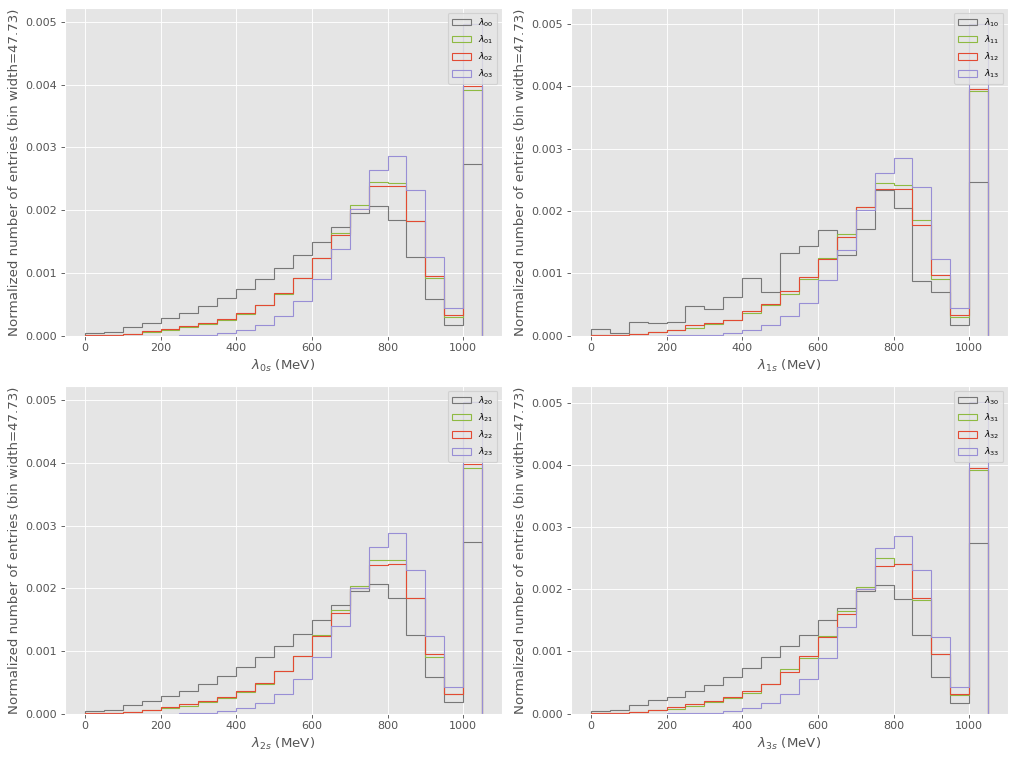

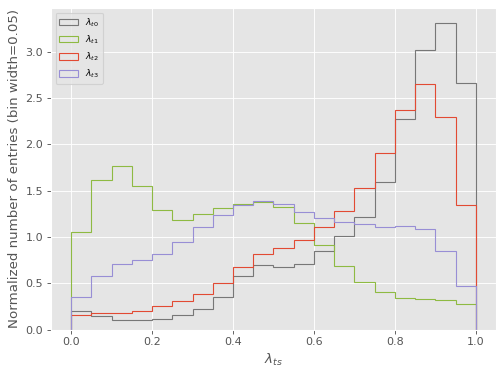

In [3]:
pdf = Plots.PlotBook("fit_templates.pdf", False)

tags = cross_section.Tags.ExclusiveProcessTags(toy_input.truth_regions)
for j, c in Plots.IterMultiPlot(templates_energy):
    for i, s in enumerate(c):
        Plots.PlotHist(energy_overflow, energy_bins, weights = s, color = tags.number[i].colour, label = f"$\lambda_{{{j}{i}}}$", xlabel = f"$\lambda_{{{j}s}}$ (MeV)", histtype = "step", newFigure = False, density = True)
pdf.Save()

plt.figure()
for i, s in enumerate(tempalates_mean_track_score):
    Plots.PlotHist(bin_centers(mean_track_score_bins), mean_track_score_bins, weights = s, color = tags.number[i].colour, label = f"$\lambda_{{t{i}}}$", xlabel = f"$\lambda_{{ts}}$", histtype = "step", newFigure = False, density = True)
plt.legend(loc = "upper left")
pdf.Save()
pdf.close()

# Validation test

model.config.suggested_init()=[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0,

counts_matrix=[[1964194, 803, 657836, 157638], [1083683, 149146, 168300, 39983], [1581902, 20323, 2142783, 284632],
[679014, 49226, 582820, 204291]]

total_count_actual, total_count, total_count_err=(9766574, 9766574.000000004, 9944.774474556418)

$mu_0$    $mu_1$    $mu_2$    $mu_3$
value  1.00000  1.000000  1.000000  1.000000
error  0.00211  0.003048  0.002206  0.005287

/home/sb16165/Documents/pi0-analysis/analysis/python/analysis/Plots.py:887: UserWarning: pdf has not been opened.
  warnings.warn("pdf has not been opened.")


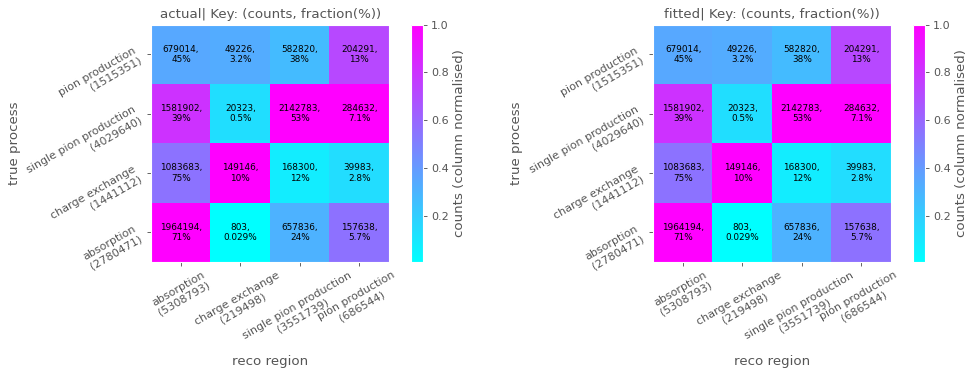

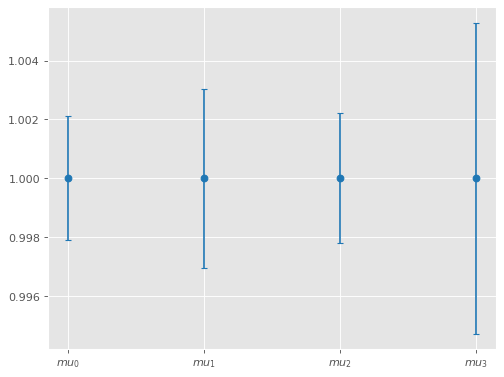

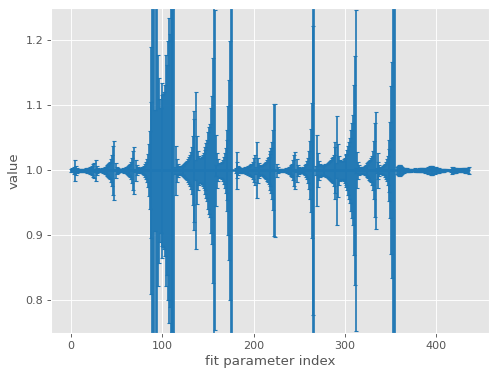

In [4]:
pdf = Plots.PlotBook("toy_validation_fit", False)
result = RegionFitToyStudy(toy_input, model, energy_slice, mean_track_score_bins, pdf = pdf)
pdf.close()

# ProtoDUNE MC Stats

In [14]:
def randint(n : int, length : int = 10):
    min = 10**(length-1)
    max = 9*min + (min-1)
    return np.random.randint(min, max, n)


def RandomSampleToy(n : int, path : str = None, df : pd.DataFrame = None, seed : int = None):
    if (path is not None) and (df is None):   
        with pd.HDFStore(path) as store:
            n_rows = store.get_storer("df").nrows
        tmp = pd.read_hdf(path, where = pd.Index(np.random.choice(range(n_rows), n)))
    elif (df is not None) and (path is None):
        tmp = df.sample(n, random_state = seed)
    elif (df is not None) and (path is not None):
        raise Exception("Either path or df must be provided, not both.")
    else:
        raise Exception("path or df must be specified")
    return tmp

# RandomSampleToy(50805, "work/2023/toys/xs_toy_1GeV_gaussian_60MeV_20M.hdf5")

In [4]:
toy_pulls = pd.read_hdf("work/2023/toys/xs_toy_1GeV_gaussian_60MeV_20M_fast_2.hdf5")

In [9]:
def Run(n : int, seed : int):
    toy = cross_section.Toy(df = RandomSampleToy(int(n), df = toy_pulls, seed = seed), smearing = True)
    puller = Pulls(toy, model, energy_bins)
    clear_output()
    return puller.ComputePulls()

def CalculatePulls(n_exp : int, n_events : int, n_cpus : int = 10):
    pool = cex_toy_generator.ProcessPool(nodes = n_cpus)
    workers = []

    seeds = randint(n_exp, length = 9)

    for i in range(n_exp):
        clear_output()
        workers.append(pool.apipe(Run, n_events, seeds[i]))
    results = [worker.get() for worker in workers]
    pool.clear()
    pool.restart()
    return np.array(results)

cross_section.SaveSelection("pulls_5E6_alt_3.dill", CalculatePulls(100, 5E6, 4))

'CreateObservedInputData' executed in 2.0875s

model.config.suggested_init()=[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0,

'CreateObservedInputData' executed in 2.1166s

model.config.suggested_init()=[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0,

'CreateObservedInputData' executed in 0.9039s

model.config.suggested_init()=[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0,

'CreateObservedInputData' executed in 0.6197s

model.config.suggested_init()=[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0,

pulls_5E6.dill

\begin{tabular}{lrrrr}
 & mu & sigma & z & p \\
$\mu_0$ & 3.452794 & 0.581196 & 59.110681 & 0.000000 \\
$\mu_1$ & -2.560546 & 0.648970 & -39.257783 & 0.000000 \\
$\mu_2$ & -1.345290 & 0.546450 & -24.495323 & 0.000000 \\
$\mu_3$ & 0.499779 & 0.586110 & 8.484300 & 0.000000 \\
\end{tabular}

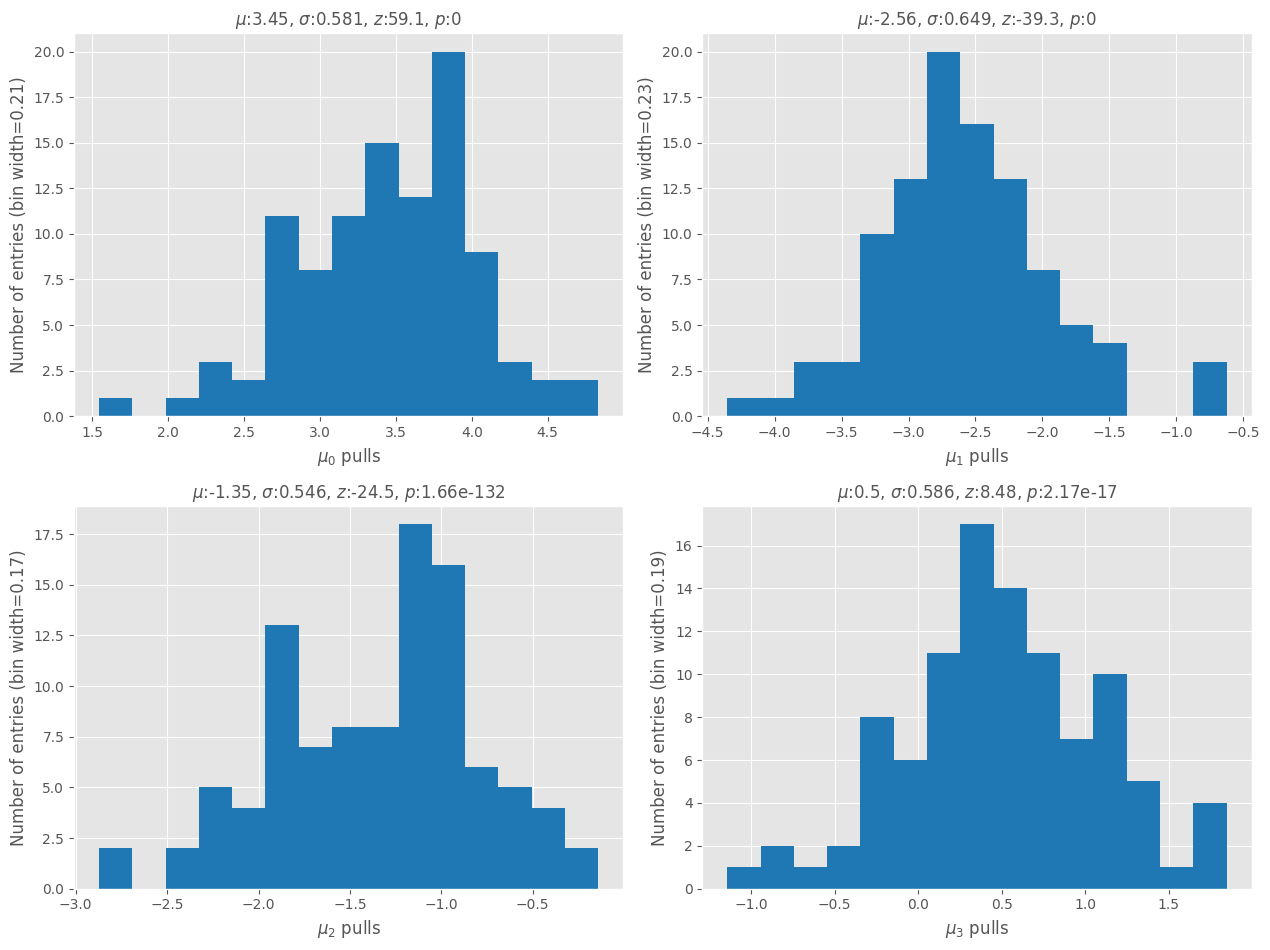

pulls_5E6_2.dill

\begin{tabular}{lrrrr}
 & mu & sigma & z & p \\
$\mu_0$ & 3.373850 & 0.638204 & 52.599741 & 0.000000 \\
$\mu_1$ & -2.503054 & 0.661032 & -37.676059 & 0.000000 \\
$\mu_2$ & -1.246788 & 0.597755 & -20.753294 & 0.000000 \\
$\mu_3$ & 0.413882 & 0.677585 & 6.077577 & 0.000000 \\
\end{tabular}

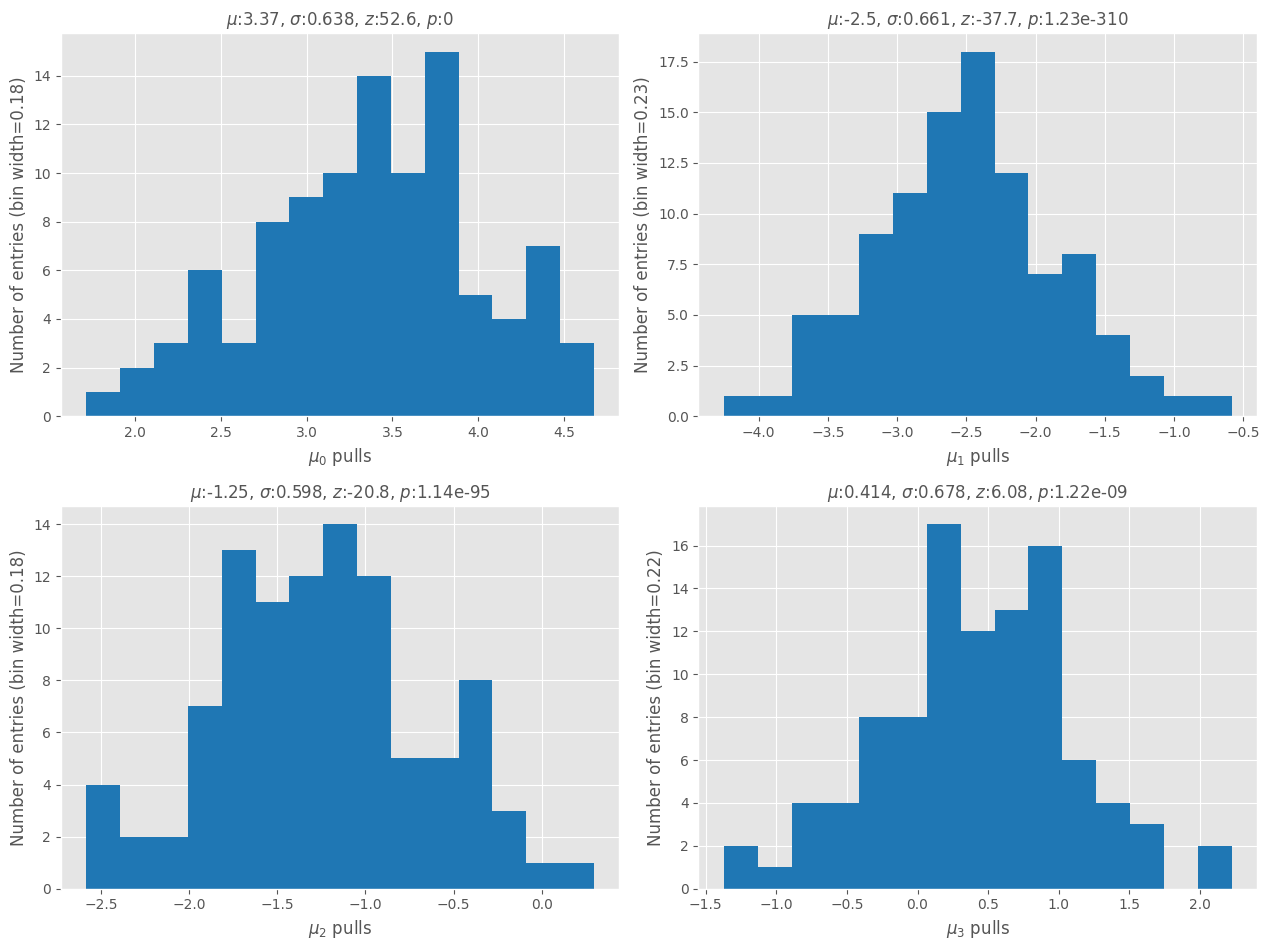

pulls_5E6_alt.dill

\begin{tabular}{lrrrr}
 & mu & sigma & z & p \\
$\mu_0$ & 1.757822 & 0.629084 & 27.802518 & 0.000000 \\
$\mu_1$ & -0.904344 & 0.704939 & -12.764381 & 0.000000 \\
$\mu_2$ & 0.989191 & 0.642534 & 15.317980 & 0.000000 \\
$\mu_3$ & -1.868511 & 0.680950 & -27.302236 & 0.000000 \\
\end{tabular}

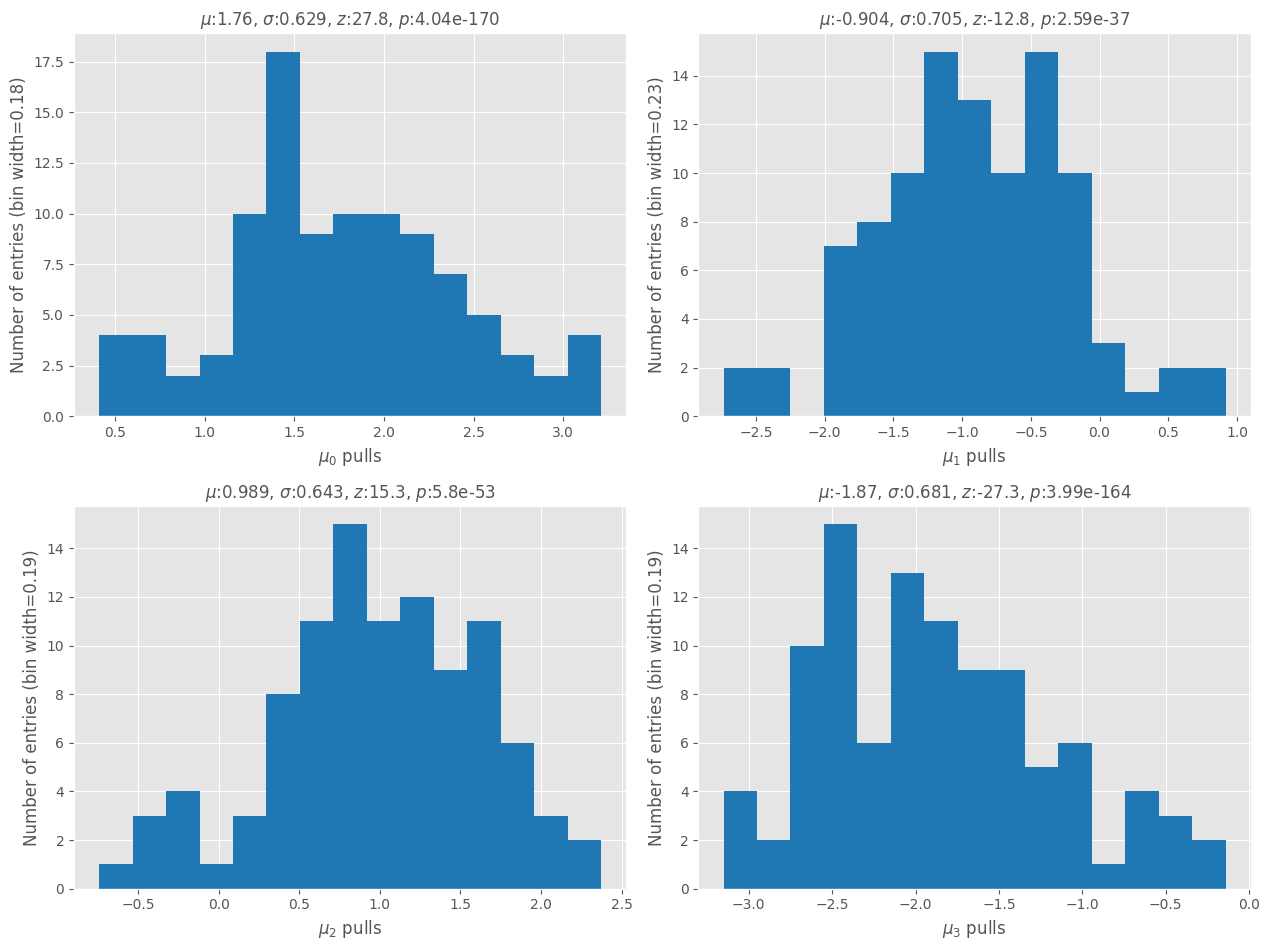

pulls_5E6_alt_2.dill

\begin{tabular}{lrrrr}
 & mu & sigma & z & p \\
$\mu_0$ & 1.734467 & 0.651387 & 26.493804 & 0.000000 \\
$\mu_1$ & -0.979548 & 0.677694 & -14.381690 & 0.000000 \\
$\mu_2$ & 1.088378 & 0.651936 & 16.610867 & 0.000000 \\
$\mu_3$ & -1.913696 & 0.676045 & -28.165341 & 0.000000 \\
\end{tabular}

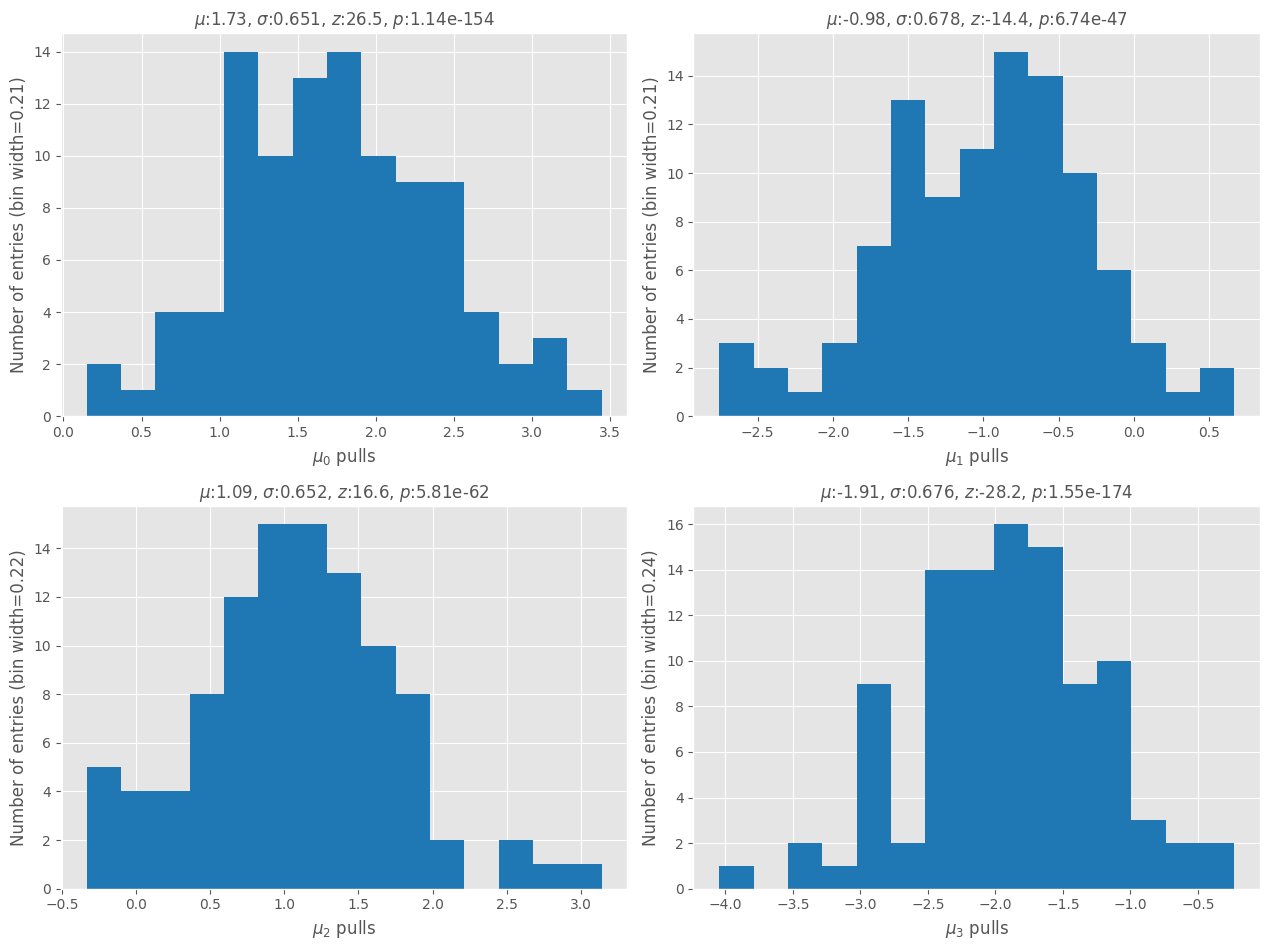

pulls_5E6_alt_3.dill

\begin{tabular}{lrrrr}
 & mu & sigma & z & p \\
$\mu_0$ & 1.652056 & 0.590902 & 27.818047 & 0.000000 \\
$\mu_1$ & -0.972705 & 0.648858 & -14.915896 & 0.000000 \\
$\mu_2$ & 1.153204 & 0.632106 & 18.152381 & 0.000000 \\
$\mu_3$ & -1.927585 & 0.650604 & -29.479131 & 0.000000 \\
\end{tabular}

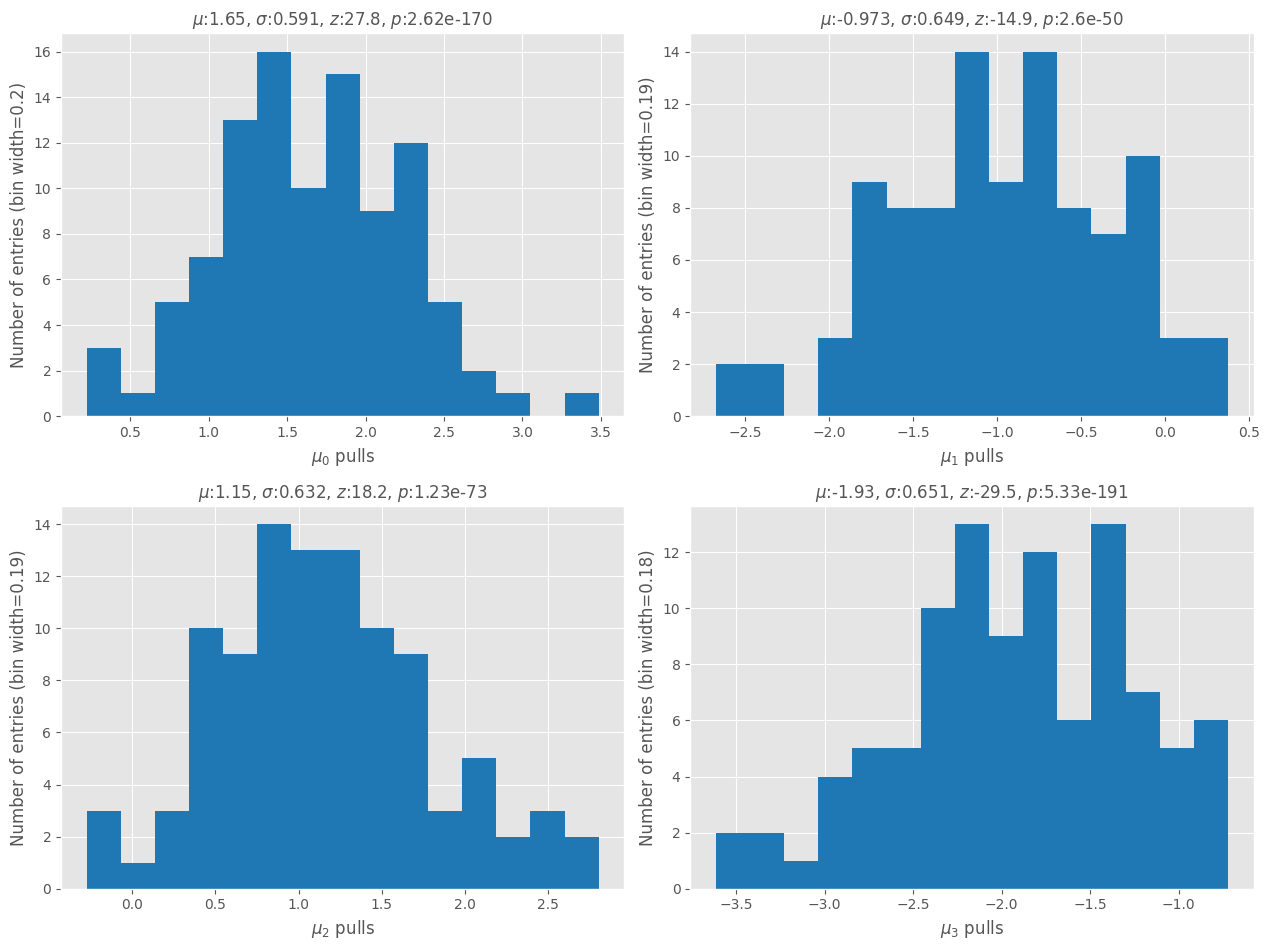

In [10]:
# ["pulls_1E4.dill", "pulls_5E4.dill", "pulls_1E5.dill", "pulls_5E5.dill", "pulls_1E6.dill", "pulls_5E6.dill"]
for p in ["pulls_5E6.dill", "pulls_5E6_2.dill", "pulls_5E6_alt.dill", "pulls_5E6_alt_2.dill", "pulls_5E6_alt_3.dill"]:
    print(p)
    pulls = cross_section.LoadSelectionFile(p)
    pulls = np.array([i for i in pulls if len(i) == 4])
    StudyPulls(pulls)
    plt.show()

In [5]:
toy_observed = cross_section.Toy(df = cex_toy_generator.main(cex_toy_generator.ResolveConfig(CreateConfig(PDSP = 1, p_init = 1000, seed = 1))), smearing = True)

'Simulate' executed in 6.8536s

'Smearing' executed in 0.0858s

'BeamSelectionEfficiency' executed in 0.0050s

'GenerateRecoRegions' executed in 0.0575s

'MeanTrackScore' executed in 0.2901s

'main' executed in 7.4173s

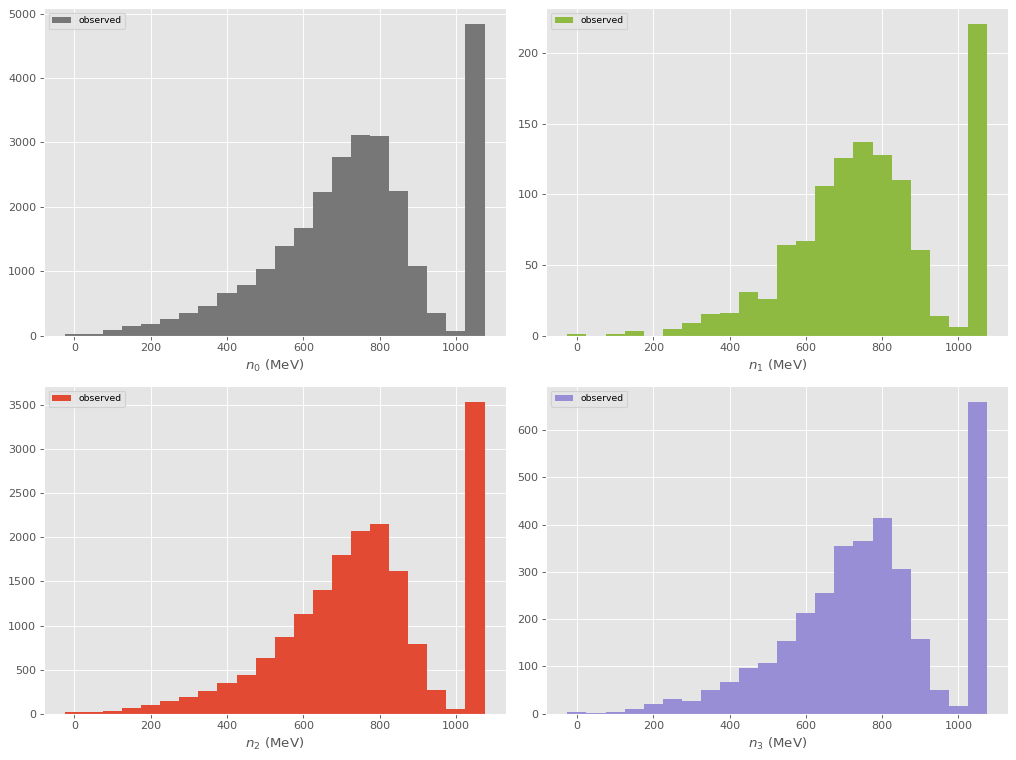

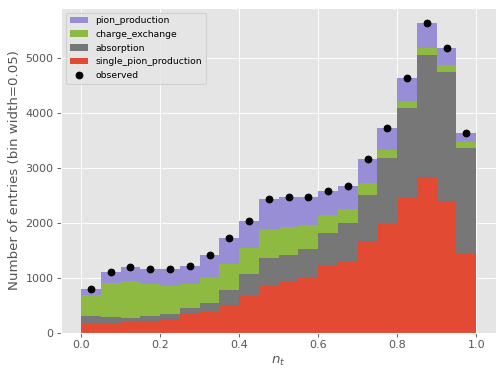

In [6]:
pdf = Plots.PlotBook("toy_observations.pdf", False)
tags = cross_section.Tags.ExclusiveProcessTags(toy_observed.truth_regions)

n_obs = cross_section.RegionFit.CreateObservedInputData(cross_section.AnalysisInput.CreateAnalysisInputToy(toy_observed), energy_slice, mean_track_score_bins)
n_obs_energy = n_obs[:-1]
n_obs_mean_track_score = n_obs[-1]
for i, r in Plots.IterMultiPlot(toy_observed.reco_region_labels):
    # Plots.PlotTagged(toy_observed.df.KE_int_smeared[toy_observed.reco_regions[r]], cross_section.Tags.ExclusiveProcessTags(toy_observed.truth_regions), energy_bins, newFigure = False)
    # Plots.PlotHist(bin_centers(energy_bins), energy_bins, weights = n_obs_energy[i], label = "observed", histtype = "step", color = "black", newFigure = False)
    Plots.Plot(energy_overflow, n_obs_energy[i], xlabel = f"$n_{{{i}}}$ (MeV)", marker = "o", color = tags[r].colour, linestyle = "-", label = "observed", style = "bar", newFigure = False)
pdf.Save()

Plots.PlotTagged(toy_observed.df.mean_track_score, tags, mean_track_score_bins)
Plots.Plot(bin_centers(mean_track_score_bins), n_obs_mean_track_score, xlabel = "$n_{t}$", marker = "o", color = "black", linestyle = "", label = "observed", newFigure = False)
pdf.Save()
pdf.close()

pdf toy_fit_low_stats.pdf has been opened
model.config.suggested_init()=[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.

counts_matrix=[[9964, 4, 3368, 813], [5582, 779, 851, 203], [8136, 107, 10887, 1393], [3264, 257, 2820, 959]]

total_count_actual, total_count, total_count_err=(49387, 49512.56898014516, 573.0664825346167)

$mu_0$    $mu_1$    $mu_2$    $mu_3$
value  0.004958  0.005380  0.005319  0.004316
error  0.000119  0.000173  0.000130  0.000308

pdf toy_fit_low_stats.pdf has been closed


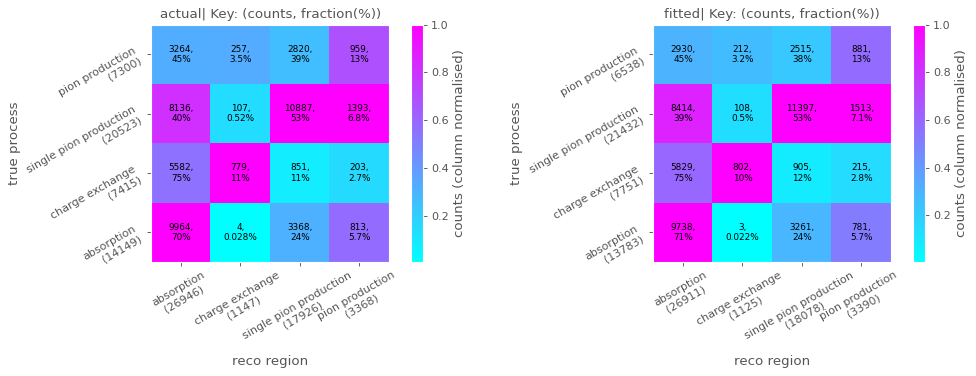

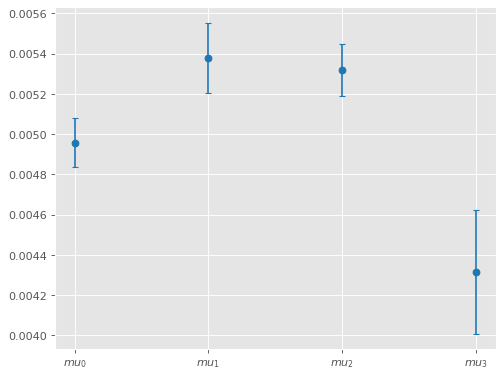

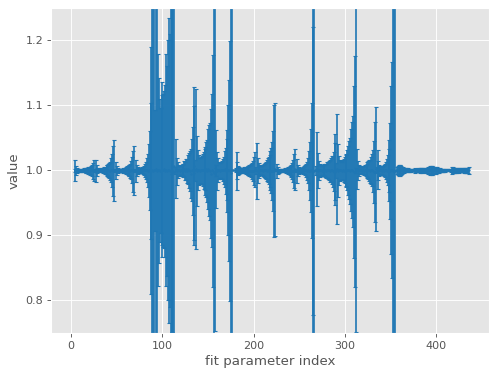

In [7]:
pdf_low_stats = Plots.PlotBook("toy_fit_low_stats.pdf", True)
result = RegionFitToyStudy(toy_observed, model, energy_slice, mean_track_score_bins, pdf = pdf_low_stats)
pdf_low_stats.close()

# Alternate correlation matrix

In [6]:
toy_alt = cross_section.Toy(file = "work/2023/toys/xs_toy_1GeV_gaussian_60MeV_fit_input.hdf5", smearing = True)
fractions = pd.read_hdf("work/2023/PDSPProd4a_MC_1GeV_reco1_sce_datadriven_v1_ntuple_v09_41_00_03/toy_parameters/reco_regions/reco_region_fractions.hdf5")

print(fractions)

fractions["pion_production"]["pion_production"] += 0.25
fractions["pion_production"]["single_pion_production"] -= 0.25

# fractions["charge_exchange"]["charge_exchange"] += 0.1
# fractions["charge_exchange"]["absorption"] -= 0.1


print(fractions)

regions = cex_toy_generator.GenerateRecoRegions(toy_input.df.exclusive_process, fractions, np.random.default_rng())
toy_alt._Toy__reco_regions = cross_section.Toy.GetRegion(regions, "reco_regions_")

absorption  charge_exchange  single_pion_production  \
absorption                0.756340         0.771416                0.440383   
charge_exchange           0.000238         0.095566                0.004684   
single_pion_production    0.196333         0.107476                0.489869   
pion_production           0.047089         0.025542                0.065065   

                        pion_production  
absorption                     0.469713  
charge_exchange                0.031233  
single_pion_production         0.369524  
pion_production                0.129529

absorption  charge_exchange  single_pion_production  \
absorption                0.756340         0.771416                0.440383   
charge_exchange           0.000238         0.095566                0.004684   
single_pion_production    0.196333         0.107476                0.489869   
pion_production           0.047089         0.025542                0.065065   

                        pion_production  
absorption                     0.469713  
charge_exchange                0.031233  
single_pion_production         0.119524  
pion_production                0.379529

'GenerateRecoRegions' executed in 15.3544s

In [9]:
cross_section.AnalysisInput.CreateAnalysisInputToy(toy_alt)

RegionFit.FitInput(regions={'absorption': array([False,  True,  True, ...,  True,  True,  True]), 'charge_exchange': array([False, False, False, ..., False, False, False]), 'single_pion_production': array([ True, False, False, ..., False, False, False]), 'pion_production': array([False, False, False, ..., False, False, False])}, outside_tpc=array([False, False, False, ..., False, False, False]), KE_int=array([790.78735067, 855.76283972, 846.89393684, ..., 792.53907374,
       808.40776848, 726.85612174]), KE_init=array([878.43655808, 827.73892447, 934.21780807, ..., 922.71766467,
       939.86234677, 802.99491719]), mean_track_score=array([0.7491085464398641, 0.631785005006679, 0.548571686403099, ...,
       0.794598364795846, 0.4354737227453884, 0.8886725692151805],
      dtype=object))

fit_input.regions={'absorption': array([False,  True,  True, ...,  True,  True,  True]), 'charge_exchange': array([False, False, False, ..., False, False, False]), 'single_pion_production': array([ True, False, False, ..., False, False, False]), 'pion_production': array([False, False, False, ..., False, False, False])}
model.config.suggested_init()=[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0

counts_matrix=[[1826895, 570, 473524, 113995], [899530, 111561, 124753, 29515], [1423759, 15303, 1583047, 210654], 
[510551, 33788, 129983, 412788]]

total_count_actual, total_count, total_count_err=(7900216, 7898231.532061219, 11216.25780495737)

$mu_0$    $mu_1$    $mu_2$    $mu_3$
value  1.391489  0.439683  0.451176  2.346546
error  0.002833  0.004277  0.003159  0.008264

/home/sb16165/Documents/pi0-analysis/analysis/python/analysis/Plots.py:887: UserWarning: pdf has not been opened.
  warnings.warn("pdf has not been opened.")


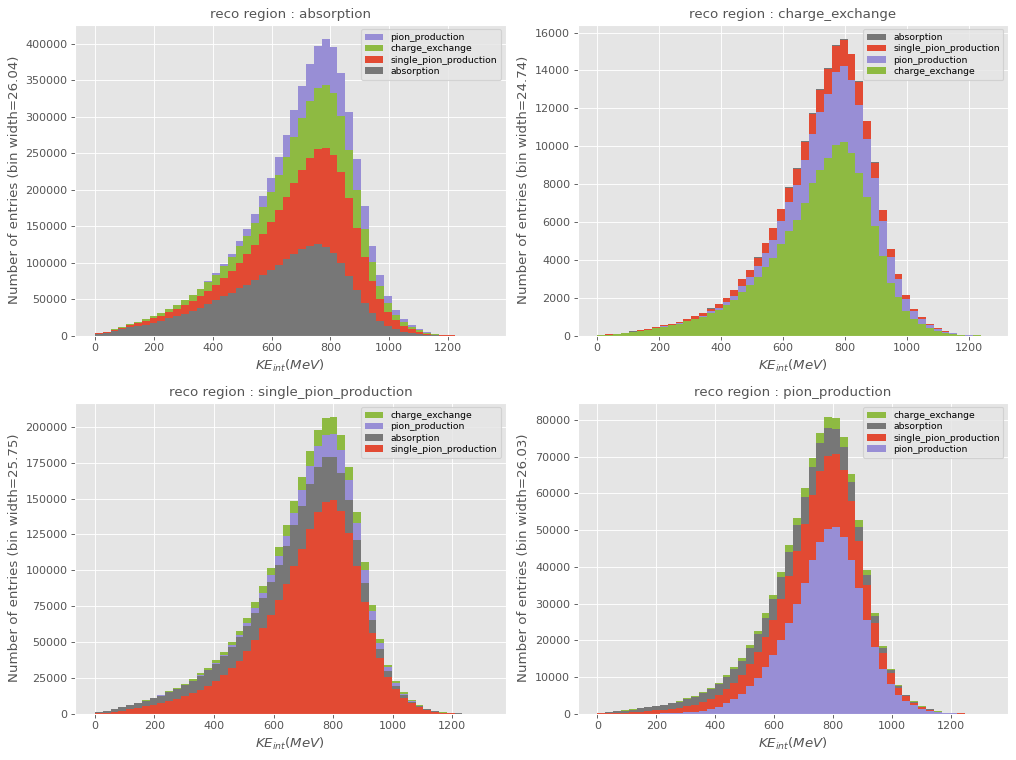

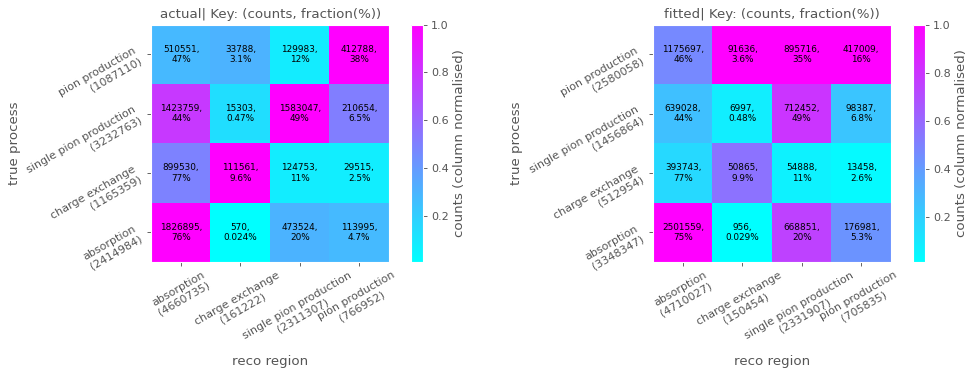

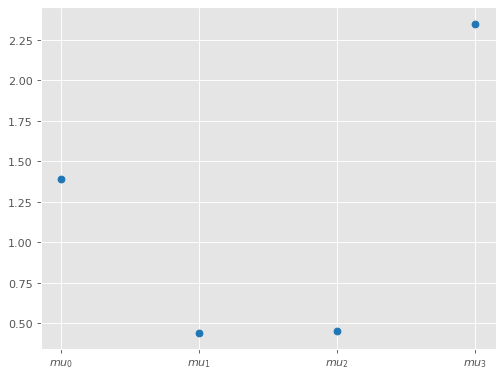

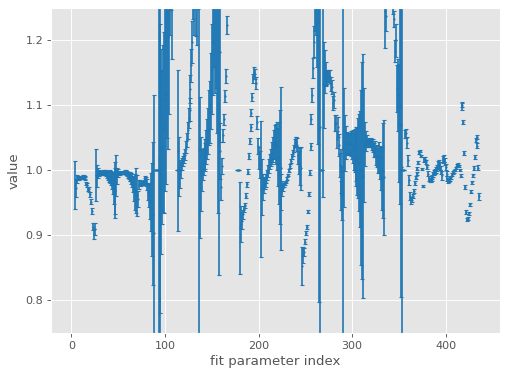

In [14]:
pdf = Plots.PlotBook("toy_vary_regions.pdf", False)
cross_section.Toy.PlotObservablesInRegions(toy_alt.df.KE_int_smeared, toy_alt.reco_regions, toy_alt.truth_regions, "$KE_{int} (MeV)$", stacked = True, histtype = "stepfilled")
result = RegionFitToyStudy(toy_alt, model, energy_slice, mean_track_score_bins, pdf = pdf)
pdf.close()

# Modified exclusive process rates

## original PDFs

'Simulate' executed in 6.6713s

'Smearing' executed in 0.0956s

'BeamSelectionEfficiency' executed in 0.0035s

'GenerateRecoRegions' executed in 0.0564s

'MeanTrackScore' executed in 0.3415s

'main' executed in 7.2931s

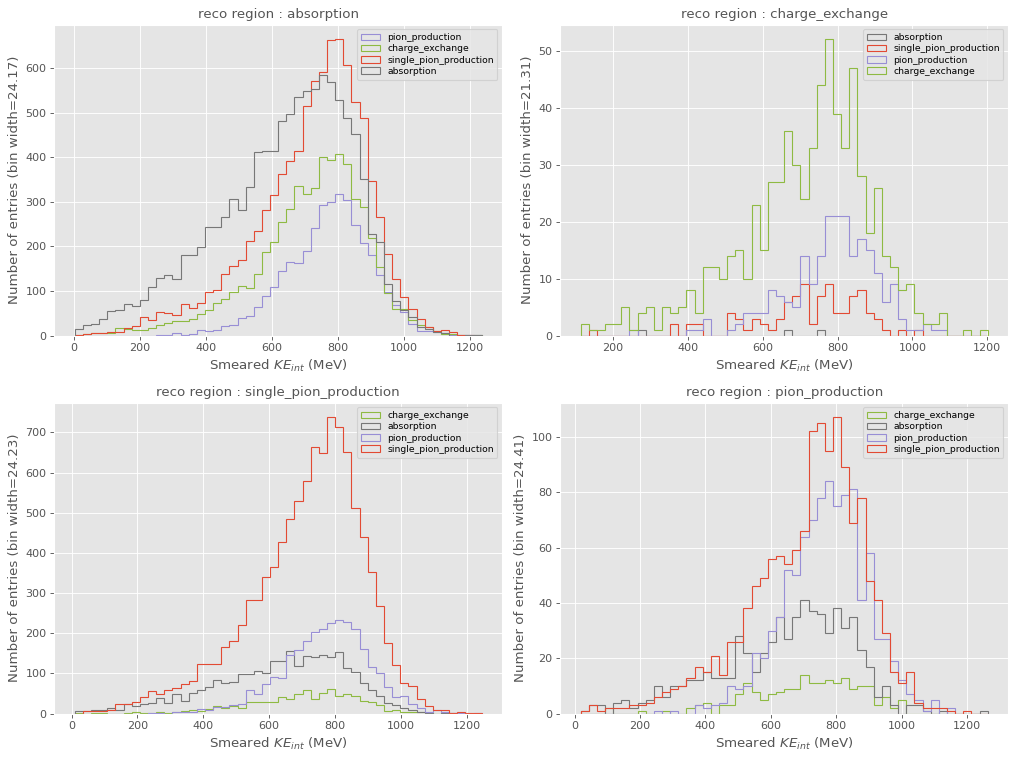

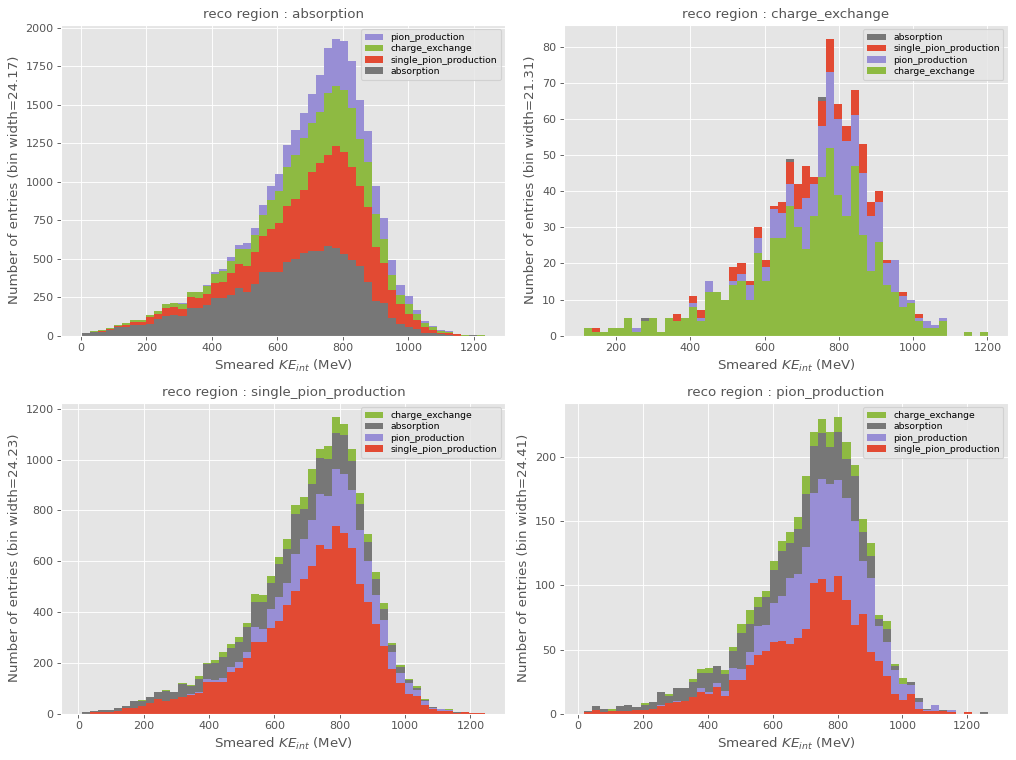

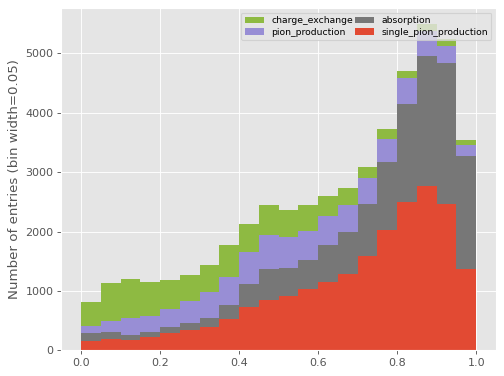

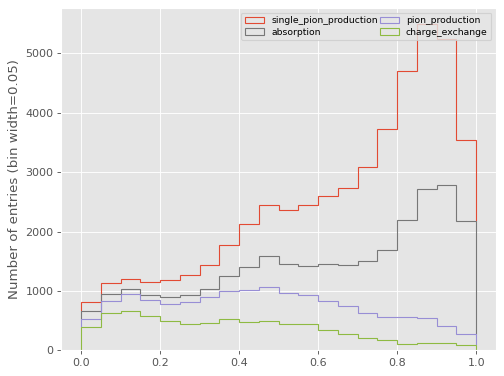

In [45]:
toy_alt_pdf = cross_section.Toy(df = cex_toy_generator.main(cex_toy_generator.ResolveConfig(CreateConfig())), smearing = True)
cross_section.Toy.PlotObservablesInRegions(toy_alt_pdf.df.KE_int_smeared, toy_alt_pdf.reco_regions, toy_alt_pdf.truth_regions, "Smeared $KE_{int}$ (MeV)")
cross_section.Toy.PlotObservablesInRegions(toy_alt_pdf.df.KE_int_smeared, toy_alt_pdf.reco_regions, toy_alt_pdf.truth_regions, "Smeared $KE_{int}$ (MeV)", stacked = True, histtype = "stepfilled")
Plots.PlotTagged(toy_alt_pdf.df.mean_track_score, tags = cross_section.Tags.ExclusiveProcessTags(toy_alt_pdf.truth_regions), bins = mean_track_score_bins)
Plots.PlotTagged(toy_alt_pdf.df.mean_track_score, tags = cross_section.Tags.ExclusiveProcessTags(toy_alt_pdf.truth_regions), bins = mean_track_score_bins, histtype = "step", reverse_sort = True)

## modified PDFs

'Simulate' executed in 7.1200s

'Smearing' executed in 0.1052s

'BeamSelectionEfficiency' executed in 0.0092s

'GenerateRecoRegions' executed in 0.0790s

'MeanTrackScore' executed in 0.2836s

'main' executed in 7.7239s

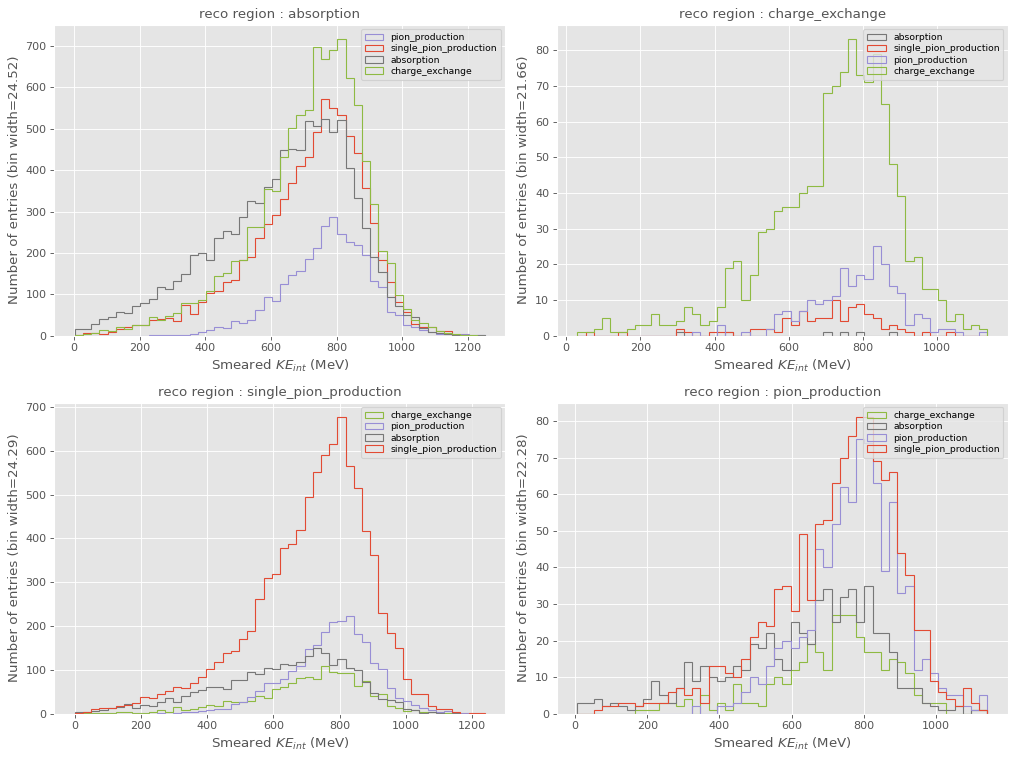

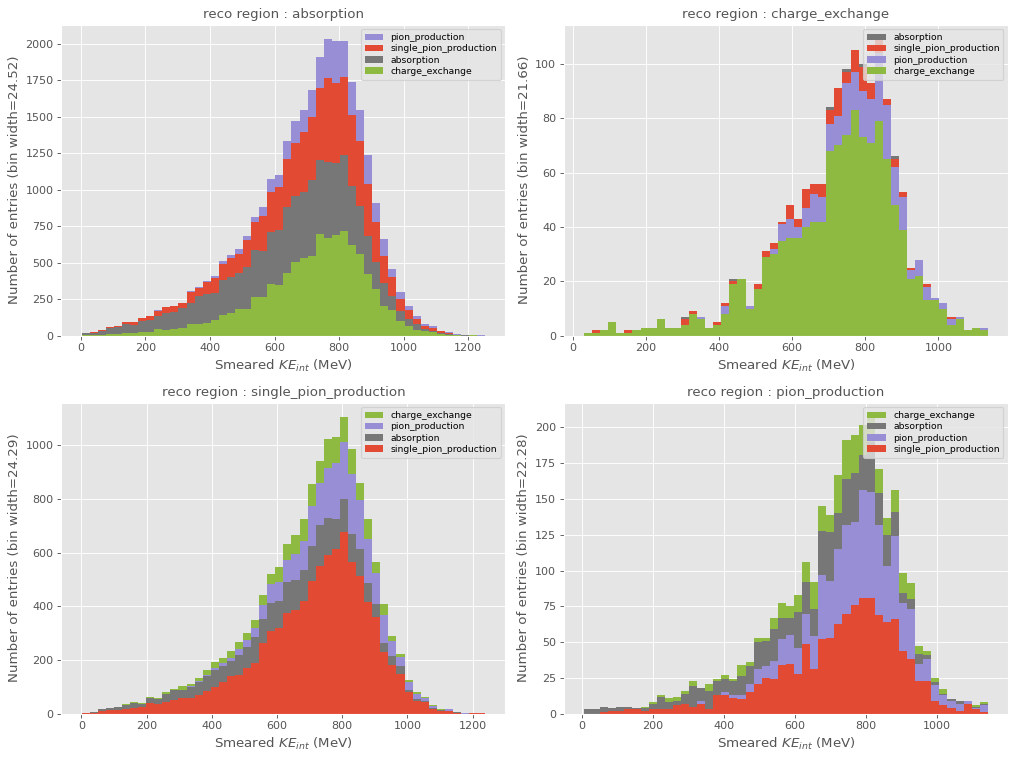

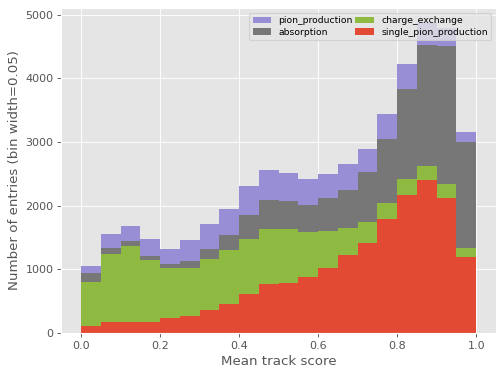

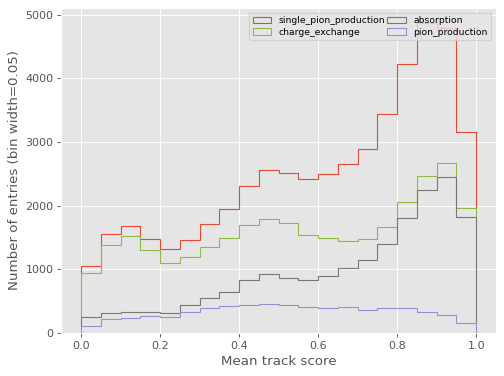

In [12]:
scales = {
    'absorption': 1,
    'quasielastic': 1,
    'charge_exchange': 2,
    'double_charge_exchange': 1,
    'pion_production': 1
    }

toy_alt_pdf = cross_section.Toy(df = cex_toy_generator.main(cex_toy_generator.ResolveConfig(CreateConfig(scale_factors = scales))), smearing = True)
cross_section.Toy.PlotObservablesInRegions(toy_alt_pdf.df.KE_int_smeared, toy_alt_pdf.reco_regions, toy_alt_pdf.truth_regions, "Smeared $KE_{int}$ (MeV)")
cross_section.Toy.PlotObservablesInRegions(toy_alt_pdf.df.KE_int_smeared, toy_alt_pdf.reco_regions, toy_alt_pdf.truth_regions, "Smeared $KE_{int}$ (MeV)", stacked = True, histtype = "stepfilled")
Plots.PlotTagged(toy_alt_pdf.df.mean_track_score, tags = cross_section.Tags.ExclusiveProcessTags(toy_alt_pdf.truth_regions), bins = mean_track_score_bins, x_label = "Mean track score")
Plots.PlotTagged(toy_alt_pdf.df.mean_track_score, tags = cross_section.Tags.ExclusiveProcessTags(toy_alt_pdf.truth_regions), bins = mean_track_score_bins, x_label = "Mean track score", histtype = "step", reverse_sort = True)

## Compare shapes

'Simulate' executed in 7.2275s

'Smearing' executed in 0.1122s

'BeamSelectionEfficiency' executed in 0.0037s

'GenerateRecoRegions' executed in 0.0544s

'MeanTrackScore' executed in 0.2823s

'main' executed in 7.8144s

'Simulate' executed in 6.9447s

'Smearing' executed in 0.1031s

'BeamSelectionEfficiency' executed in 0.0043s

'GenerateRecoRegions' executed in 0.0594s

'MeanTrackScore' executed in 0.2948s

'main' executed in 7.5297s

'Simulate' executed in 7.2070s

'Smearing' executed in 0.1074s

'BeamSelectionEfficiency' executed in 0.0084s

'GenerateRecoRegions' executed in 0.0737s

'MeanTrackScore' executed in 0.3554s

'main' executed in 7.8883s

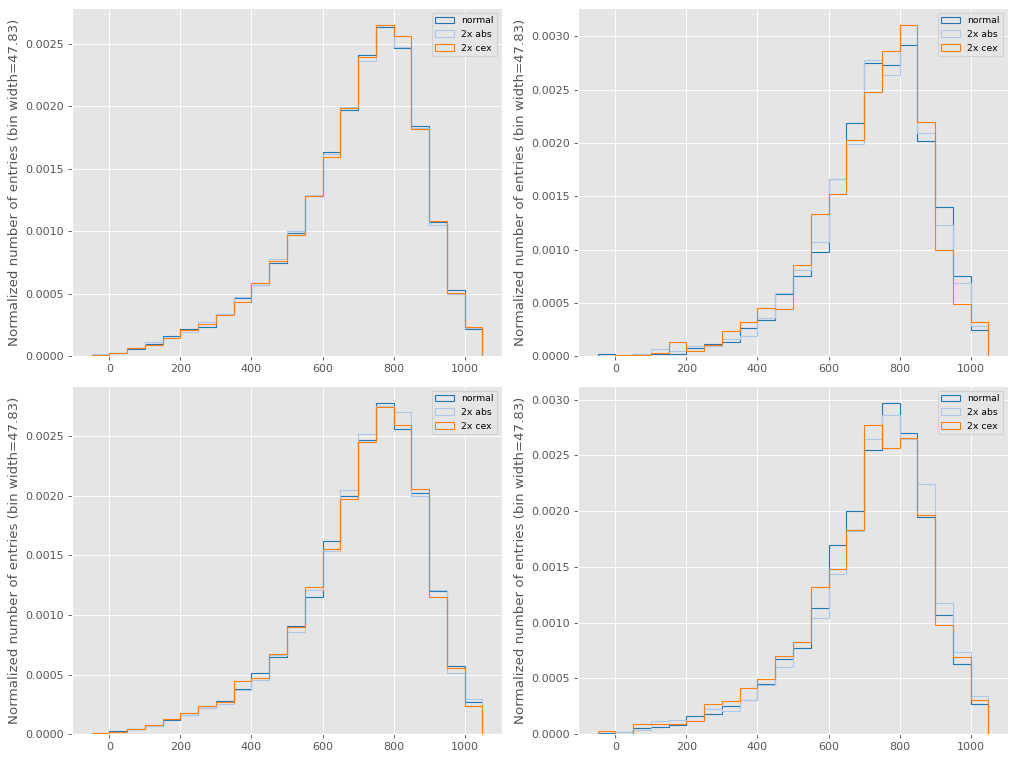

In [13]:
scales_original = {'absorption': 1, 'quasielastic': 1, 'charge_exchange': 1, 'double_charge_exchange': 1, 'pion_production': 1}
scales_abs = {'absorption': 2, 'quasielastic': 1, 'charge_exchange': 1, 'double_charge_exchange': 1, 'pion_production': 1}
scales_cex = {'absorption': 1, 'quasielastic': 1, 'charge_exchange': 2, 'double_charge_exchange': 1, 'pion_production': 1}

toys = [cross_section.Toy(df = cex_toy_generator.main(cex_toy_generator.ResolveConfig(CreateConfig(scale_factors = s))), smearing = True) for s in [scales_original, scales_abs, scales_cex]]
for _, r in Plots.IterMultiPlot(toy_input.reco_regions.columns): 
    data = [toy.df.KE_int_smeared[toy.reco_regions[r]] for toy in toys]
    Plots.PlotHistComparison(data, labels = ["normal", "2x abs", "2x cex"], bins = energy_bins, newFigure = False)

## Fits for different rates

In [46]:
def PlotFitResults(results, true_counts, target : str, pdf : Plots.PlotBook = None):
    colours = {
        "absorption"      : "#777777",
        "charge_exchange" : "#8EBA42",
        "single_pion_production" : "#E24A33",
        "pion_production" : "#988ED5",
    }

    mu = []
    mu_err = []
    for result in results.values():
        mu.append(result.bestfit[0:4])
        mu_err.append(result.uncertainty[0:4])
    mu = np.array(mu)
    mu_err = np.array(mu_err)

    xlabel = f"{target} scale factor"

    # Plot the fit value for each scale factor 
    plt.figure()
    for i in range(4):
        Plots.Plot(list(range(len(results))), mu[:, i], yerr = mu_err[:, i], newFigure = False, label = f"$\mu_{i}$", marker = "o", ylabel = "fit value", color = list(colours.values())[i])
    Plots.plt.xticks(ticks = list(range(len(results))), labels = results.keys())
    Plots.plt.xlabel(xlabel)
    if pdf: pdf.Save()

    # same as above, in separate plots
    for i in Plots.MultiPlot(4):
        Plots.Plot(list(range(len(results))), mu[:, i], yerr = mu_err[:, i], newFigure = False, label = f"$\mu_{i}$", marker = "o", xlabel = xlabel, ylabel = "fit value", color = list(colours.values())[i])
    Plots.plt.xticks(ticks = list(range(len(results))), labels = results.keys())
    if pdf: pdf.Save()

    true_counts_pred_res = {}
    true_counts_pred_res_err = {}
    for k, v in results.items():
        post_fit_pred = cross_section.cabinetry.model_utils.prediction(model, fit_results = v, label = "post-fit")
        # post_fit_pred = SliceModelPrediction(post_fit_pred, slice(-1), "KE_int_postfit") # remove mean track score results
        # print(f"{post_fit_pred.total_stdev_model_channels=}")
        true_counts_pred_res_err[k] = np.sum(post_fit_pred.total_stdev_model_channels, 0)[:-1]
        true_counts_pred_res[k] = {toy_input.truth_region_labels[j] : int(np.sum([post_fit_pred.model_yields[i][j] for i in range(len(toy_input.reco_region_labels))])) - true_counts[k][toy_input.truth_region_labels[j]] for j in range(len(toy_input.truth_region_labels))}

    true_counts = pd.DataFrame(true_counts)
    true_counts_pred_res = pd.DataFrame(true_counts_pred_res)
    true_counts_pred_res_err = pd.DataFrame(true_counts_pred_res_err, index = true_counts_pred_res.index)

    # plot true process residual
    for n, i in Plots.IterMultiPlot(true_counts.index):
        print(n, i)
        Plots.Plot(true_counts_pred_res.columns, true_counts_pred_res.loc[i], yerr = true_counts_pred_res_err.loc[i], title = f"$\mu_{n}$", xlabel = xlabel, ylabel = "predicted counts - true counts", linestyle = "", marker = "o", color = list(colours.values())[n], newFigure = False)
        plt.axhline(0, color = "black", linestyle = "--")
    if pdf: pdf.Save()


def ModifiedRateTest(scales : dict, pdf_name : str = None, pulls : bool = False):
    if pdf_name is not None:
        pdf = Plots.PlotBook(pdf_name)
        pdf.open()
    else:
        pdf = None

    config = CreateConfig(scale_factors = scales)

    toy_alt_pdf = cross_section.Toy(df = cex_toy_generator.main(cex_toy_generator.ResolveConfig(config)), smearing = True)
    cross_section.Toy.PlotObservablesInRegions(toy_alt_pdf.df.KE_int_smeared, toy_alt_pdf.reco_regions, toy_alt_pdf.truth_regions, "Smeared $KE_{int}$ (MeV)")
    if pdf_name is not None: pdf.Save()
    result = RegionFitToyStudy(toy_alt_pdf, model, energy_slice, mean_track_score_bins, pdf = pdf)
    if pdf_name is not None: pdf.close()

    # mask = (toy_alt_pdf.df.KE_int_smeared > 0) & (toy_alt_pdf.df.KE_int_smeared < 1050) & (toy_alt_pdf.df.inclusive_process != "decay")
    # true_process_counts = {v : np.sum(toy_alt_pdf.truth_regions[v] & mask, 0) for v in toy_alt_pdf.truth_regions.columns}

    # true_process_counts = {v : sum(cross_section.EnergySlice.CountingExperiment(toy_alt_pdf.df.KE_int_smeared, toy_alt_pdf.df.KE_init_smeared, outside_tpc, toy_alt_pdf.truth_regions[v], energy_slice)[0]) }
    true_process_counts = {}
    for v in toy_alt_pdf.truth_regions.columns:
        true_process_counts[v] = sum(toy_alt_pdf.NInteract(energy_slice, toy_alt_pdf.truth_regions[v]))
        # n_interact = cross_section.EnergySlice.CountingExperiment(toy_alt_pdf.df.KE_int_smeared, toy_alt_pdf.df.KE_init_smeared, toy_alt_pdf.outside_tpc_smeared, toy_alt_pdf.truth_regions[v], energy_slice, interact_only = True)
        # true_process_counts[v] = sum(n_interact[:-1])


    expected_mus = [sum(toy_alt_pdf.truth_regions[r]) / sum(toy_input.truth_regions[r]) for r in toy_alt_pdf.truth_regions]

    if pdf_name is not None: Plots.plt.close("all")
    return result, true_process_counts, expected_mus, None

pdf test/region_fit_tests/fit_results_pip.pdf has been opened


0 absorption

1 charge_exchange

2 single_pion_production

3 pion_production

pdf test/region_fit_tests/fit_results_pip.pdf has been closed


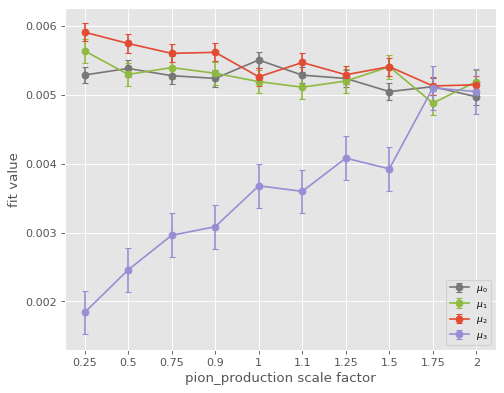

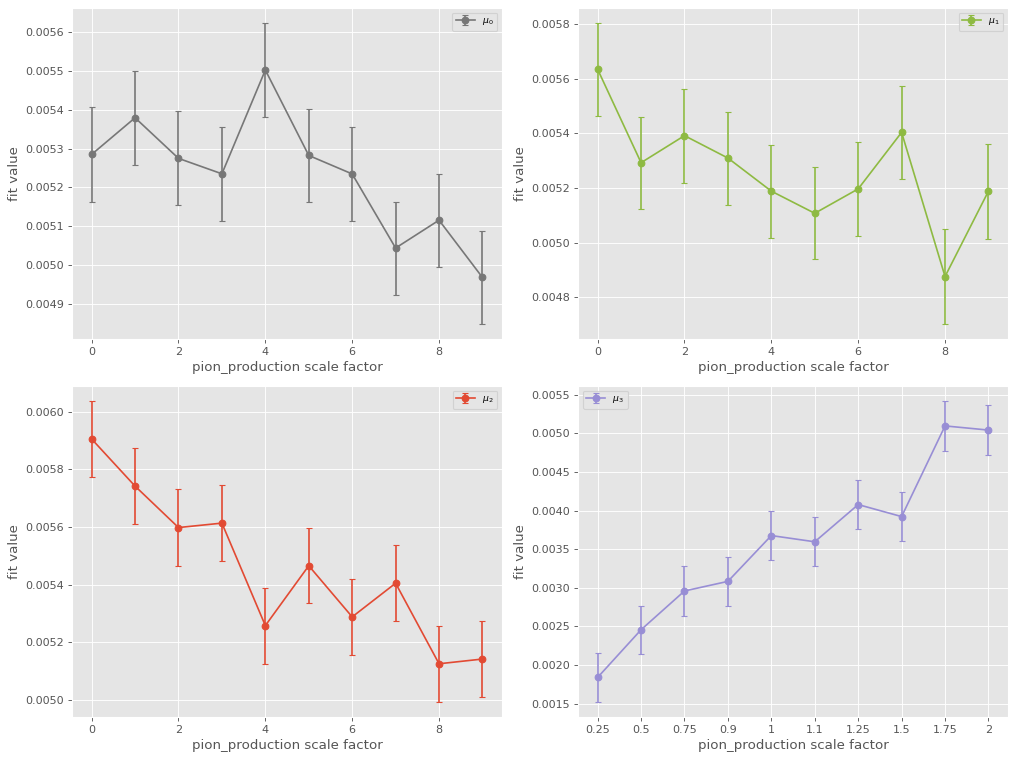

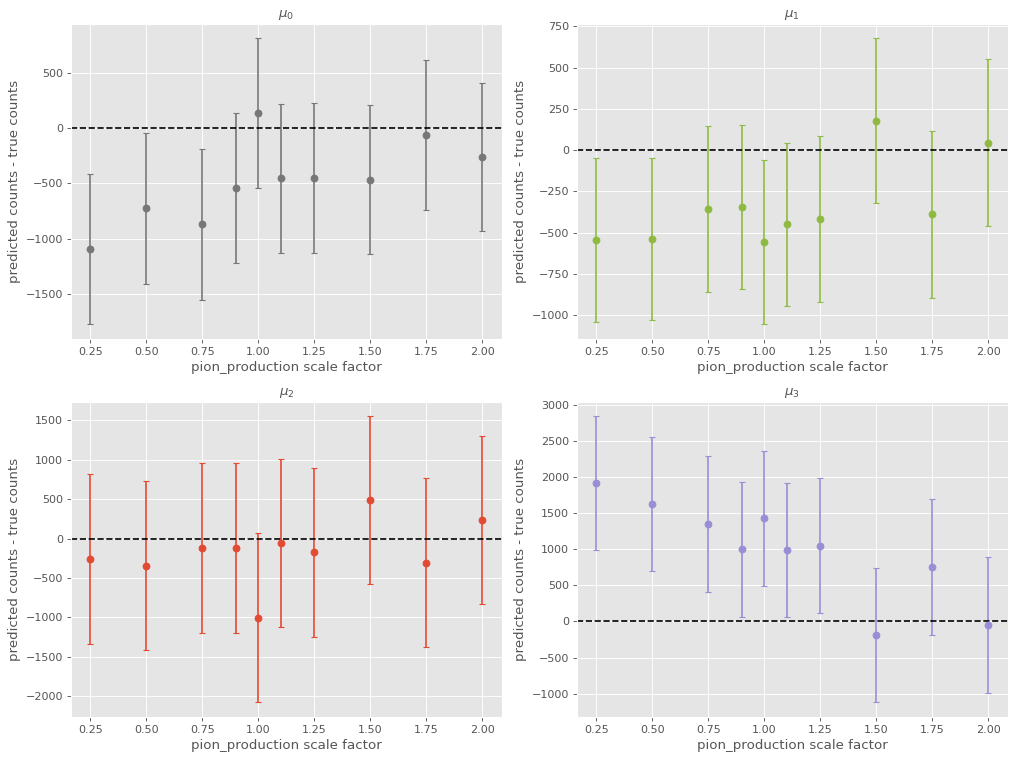

In [47]:
scales = {
    'absorption': 1,
    'quasielastic': 1,
    'charge_exchange': 1,
    'double_charge_exchange': 1,
    'pion_production': 1
    }

results = {}
true_counts = {}
pulls = {}
expected_mus = {}

folder = {
    'absorption': "abs",
    'quasielastic': "quasi",
    'charge_exchange': "cex",
    'double_charge_exchange': "dcex",
    'pion_production': "pip"
}

# target = "quasielastic"
for target in scales:
    dire = f"test/region_fit_tests/"
    for i in [0.25, 0.5, 0.75, 0.9, 1, 1.1, 1.25, 1.5, 1.75, 2]:
        scales[target] = i
        results[i], true_counts[i], expected_mus[i], pulls[i], = ModifiedRateTest(scales, f"{dire}fit_results_{folder[target]}.pdf", pulls = False)
        clear_output()
    with Plots.PlotBook(f"{dire}fit_results_{folder[target]}.pdf") as pdf:
        PlotFitResults(results, true_counts, target, pdf)

In [73]:
scales_original = {'absorption': 1, 'quasielastic': 1, 'charge_exchange': 1, 'double_charge_exchange': 2, 'pion_production': 1}
pulls = CalculatePulls(100, CreateConfig(scales_original), model, energy_bins),

'CreateObservedInputData' executed in 0.0053s

model.config.suggested_init()=[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0,

In [ ]:
# pulls = np.array([p for p in pulls if len(p) == 4])
with Plots.PlotBook("test/region_fit_tests/dcex/pulls.pdf") as pdf:
    StudyPulls(pulls)
    pdf.Save()

In [ ]:
cross_section.SaveSelection("var_abs_pulls.dill", pulls)
fits = cross_section.LoadSelectionFile("var_abs_pulls.dill")
for k, v in fits.items():
    print(f"scale factor: {k}")
    print(expected_mus[k])
    # print(fits)
    StudyPulls(v, 0.005)

# modified PDF shapes

In [61]:
class lognormal_gaussian_exp(cross_section.Fitting.FitFunction):
    n_params = 8

    def __new__(cls, x, p0, p1, p2, p3, p4, p5, p6, p7) -> np.array:
        return cls.func(x, p0, p1, p2, p3, p4, p5, p6, p7)

    def func(x, p0, p1, p2, p3, p4, p5, p6, p7):
        lognormal_component = lognorm.pdf(x, s = p2, scale = p1)
        gaussian_component = norm.pdf(x, loc=p4, scale=p5)
        exponential_component = np.exp(-p7 * x)
        return p0 * lognormal_component + p3 * gaussian_component + p6 * exponential_component # Adjust weights as needed

    def bounds(x, y):
        lims = np.array([
            (0, 1),
            (min(x), max(x)),
            (0.001, np.inf),

            (0, 1),
            (min(x), max(x)),
            (0.001, np.inf),

            (-np.inf, np.inf),
            (-np.inf, np.inf),

        ])
        return (lims[:, 0], lims[:, 1])    


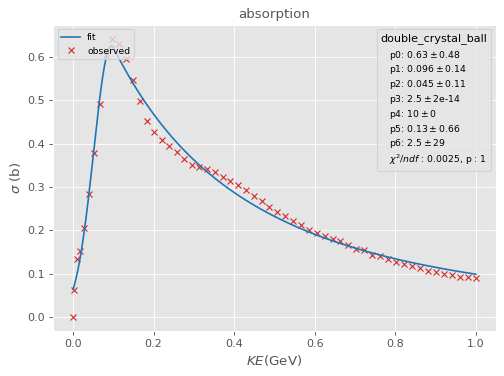

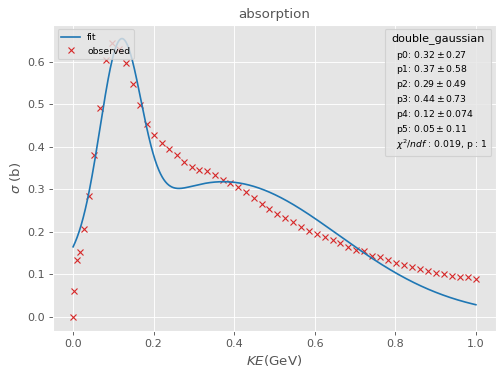

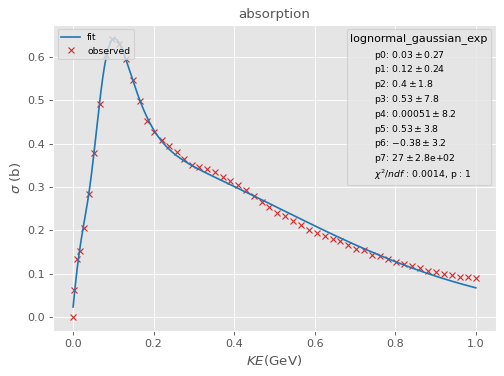

In [62]:
def FitSimulationCurve(sampling_factor : bool, process : str, function : cross_section.Fitting.FitFunction):
    x = xs_sim.KE[::sampling_factor]/1000
    y = getattr(xs_sim, process)[::sampling_factor]/1000

    plt.figure()
    results = cross_section.Fitting.Fit(x, y, None, f, method = "dogbox", plot = True, xlabel = "$KE$(GeV)", ylabel = "$\sigma$ (b)", title = process)
    return results

xs_sim = cross_section.GeantCrossSections(energy_range = energy_range)

sampling_factor = 20

book = Plots.PlotBook("absorption_fit_attempts.pdf", False)
for f in [cross_section.Fitting.double_crystal_ball, cross_section.Fitting.double_gaussian, lognormal_gaussian_exp]:
    FitSimulationCurve(sampling_factor, "absorption", f)
    book.Save()
book.close()

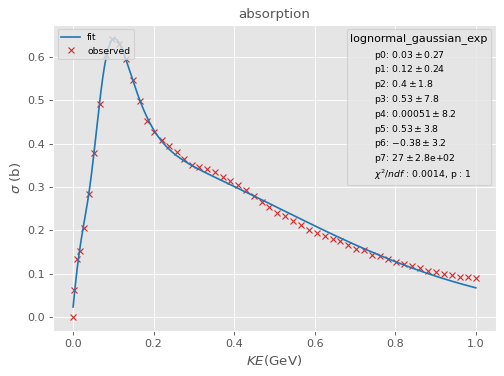

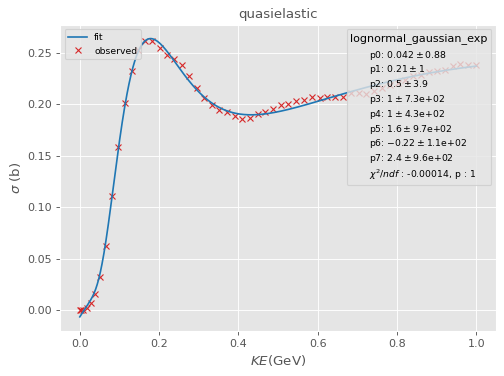

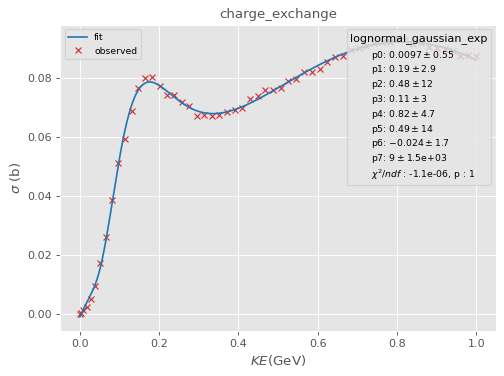

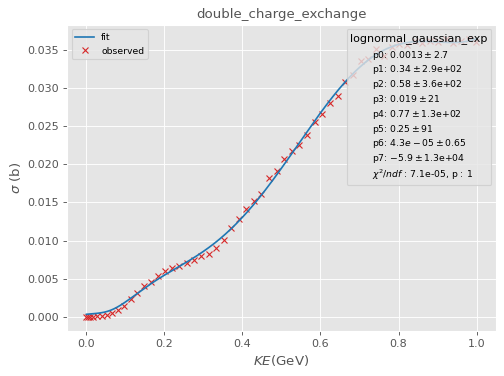

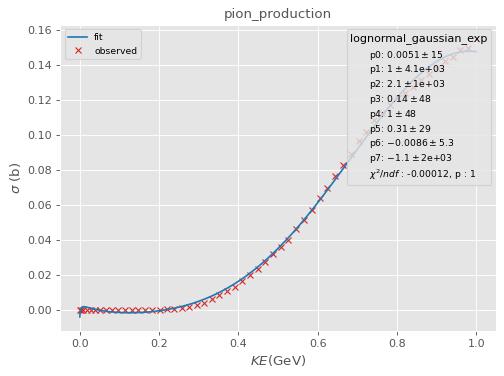

In [63]:
results = {}
for i in xs_sim.exclusive_processes:
    results[i] = FitSimulationCurve(20, i, lognormal_gaussian_exp)

In [64]:
def CreateModPDFDict(KE, xs) -> dict[np.array]:
    return {
        "KE" : KE,
        "absorption" : xs
    }

toy_nominal = cross_section.Toy(df = cex_toy_generator.main(cex_toy_generator.ResolveConfig(CreateConfig(seed = 1))), smearing = True)
toy_parameterised = cross_section.Toy(df = cex_toy_generator.main(cex_toy_generator.ResolveConfig(CreateConfig(seed = 1, modified_PDFs = CreateModPDFDict(xs_sim.KE * 1000, lognormal_gaussian_exp(xs_sim.KE, *results["absorption"][0]) * 1000) ))), smearing = True)

'Simulate' executed in 7.1254s

'Smearing' executed in 0.0886s

'BeamSelectionEfficiency' executed in 0.0037s

'GenerateRecoRegions' executed in 0.0539s

'MeanTrackScore' executed in 0.2822s

'main' executed in 7.6719s

'Simulate' executed in 6.7511s

'Smearing' executed in 0.0968s

'BeamSelectionEfficiency' executed in 0.0034s

'GenerateRecoRegions' executed in 0.0542s

'MeanTrackScore' executed in 0.2798s

'main' executed in 7.3306s

pdf parameterised_nominal_comparison.pdf has been opened
pdf parameterised_nominal_comparison.pdf has been closed


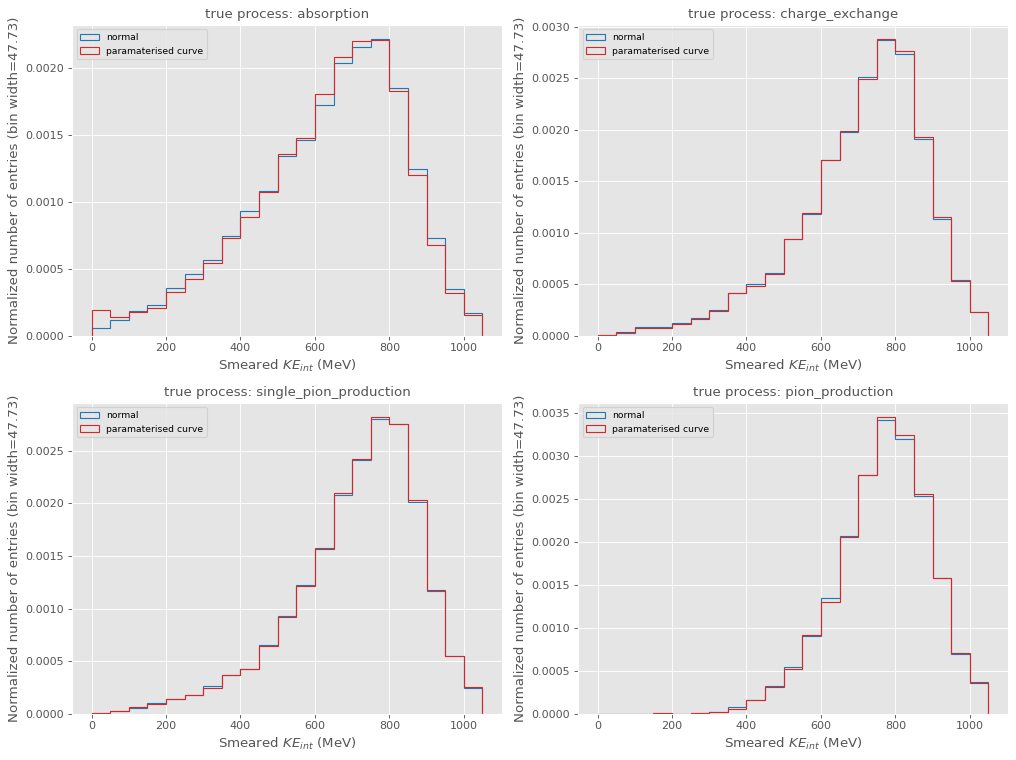

In [65]:
with Plots.PlotBook("parameterised_nominal_comparison.pdf") as book:
    for _, t in Plots.IterMultiPlot(toy_nominal.truth_region_labels):
        Plots.PlotHistComparison([toy_nominal.df.KE_int_smeared[toy_nominal.truth_regions[t]], toy_parameterised.df.KE_int_smeared[toy_parameterised.truth_regions[t]]], labels = ["normal", "paramaterised curve"], colours = ["C0", "C6"], xlabel = "Smeared $KE_{int}$ (MeV)", title = f"true process: {t}", bins = energy_bins, x_range = [0, max(energy_bins)], newFigure = False)
        plt.legend(loc = "upper left")
    book.Save()

In [ ]:
def ModifiedShapeTest(modified_pdf : dict[np.array], seed : int = 1):
    # cross_section.Toy.PlotObservablesInRegions(toy_alt_pdf.df.KE_int_smeared, toy_alt_pdf.reco_regions, toy_alt_pdf.truth_regions, "Smeared $KE_{int}$ (MeV)")

    config = CreateConfig(modified_PDFs = modified_pdf, seed = seed)
    toy = cross_section.Toy(df = cex_toy_generator.main(cex_toy_generator.ResolveConfig(config)), smearing = True)


    try:
        result = RegionFitToyStudy(toy, model, energy_slice, mean_track_score_bins)
    except:
        result = None
    true_process_counts = {}
    for v in toy.truth_regions.columns:
        true_process_counts[v] = sum(toy.NInteract(energy_slice, toy.truth_regions[v]))
    expected_mus = [sum(toy.truth_regions[r]) / sum(toy_input.truth_regions[r]) for r in toy.truth_regions]
    plt.cla()

    KE = toy.df.KE_int
    reco_regions = toy.reco_regions
    truth_regions = toy.truth_regions

    return {
        "result" : result,
        "true_counts" : true_process_counts,
        "expected_mus" : expected_mus,
        "KE" : KE,
        "reco_regions" : reco_regions,
        "truth_regions" : truth_regions
    }


def PlotResidual(results : list[cross_section.cabinetry.model_utils.FitResults], true_counts : list[dict], labels : dict[str], book : Plots.PlotBook):
    colours = {
        "absorption"      : "#777777",
        "charge_exchange" : "#8EBA42",
        "single_pion_production" : "#E24A33",
        "pion_production" : "#988ED5",
    }

    mu = []
    mu_err = []
    for result in results:
        mu.append(result.bestfit[0:4])
        mu_err.append(result.uncertainty[0:4])
    mu = np.array(mu)
    mu_err = np.array(mu_err)

    xlabel = f"p{p}"

    # Plot the fit value for each scale factor 
    plt.figure()
    for i in range(4):
        Plots.Plot(list(range(len(results))), mu[:, i], yerr = mu_err[:, i], newFigure = False, label = f"$\mu_{i}$", marker = "o", ylabel = "fit value", color = list(colours.values())[i])
    Plots.plt.xticks(ticks = list(range(len(results))), labels = labels)
    Plots.plt.xlabel(xlabel)
    book.Save()

    # same as above, in separate plots
    for i in Plots.MultiPlot(4):
        Plots.Plot(list(range(len(results))), mu[:, i], yerr = mu_err[:, i], newFigure = False, label = f"$\mu_{i}$", marker = "o", xlabel = xlabel, ylabel = "fit value", color = list(colours.values())[i])
        Plots.plt.xticks(ticks = list(range(len(results))), labels = labels)
    book.Save()

    true_counts_pred_res = []
    true_counts_pred_res_err = []
    for n, (k, v) in enumerate(zip(labels, results)):
        post_fit_pred = cross_section.cabinetry.model_utils.prediction(model, fit_results = v, label = "post-fit")
        true_counts_pred_res_err.append(np.sum(post_fit_pred.total_stdev_model_channels, 0)[:-1])
        true_counts_pred_res.append([int(np.sum([post_fit_pred.model_yields[i][j] for i in range(len(toy_input.reco_region_labels))])) - true_counts[n][toy_input.truth_region_labels[j]] for j in range(len(toy_input.truth_region_labels))])

    true_counts_array = np.array([list(d.values()) for d in true_counts]) # axis 0 is experiment, axis 1 is process
    true_counts_pred_res = np.array(true_counts_pred_res)
    true_counts_pred_res_err = np.array(true_counts_pred_res_err)

    for i in Plots.MultiPlot(true_counts_array.shape[1]):
        Plots.Plot(labels, true_counts_pred_res[:, i], yerr = true_counts_pred_res_err[:, i], title = f"$\mu_{n}$", xlabel = xlabel, ylabel = "predicted counts - true counts", linestyle = "", marker = "o", color = list(colours.values())[i], newFigure = False)
        plt.axhline(0, color = "black", linestyle = "--")
        Plots.plt.xticks(ticks = list(range(len(results))), labels = labels)

    book.Save()
    return


def ModifiedPDFs(parameter_index : int, n_points : int, change : float, results : tuple, book : Plots.PlotBook) -> dict[np.array]:
    parameter_range = [-change * results[0][parameter_index], change * results[0][parameter_index]]

    x_1 = np.linspace(0, 1, 1000)

    modified_PDFs = {}

    plt.figure()
    for i in np.linspace(min(parameter_range), max(parameter_range), n_points, True):
        modified_params = np.array(results[0])
        modified_params[parameter_index] = modified_params[parameter_index] + i

        y = lognormal_gaussian_exp(x_1, *modified_params)
        if min(y) < 0:
            y = y - min(y)

        Plots.Plot(x_1*1000, y*1000, newFigure = False, xlabel = "KE (MeV)", ylabel = "$\sigma$ (mb)", label = f"p{p}={modified_params[p]:.2g}")
        
        label = f"{100 * i:.2f}"

        modified_PDFs[label] = CreateModPDFDict(x_1*1000, y*1000)
    book.Save()
    return modified_PDFs


def KEPlots(KE, reco_regions, truth_regions, labels, book : Plots.PlotBook):
    # absorption_KE
    for _, t in Plots.IterMultiPlot(toy_input.truth_region_labels):
        data = [KE[i][truth_regions[i][t]] for i in range(len(labels))]
        Plots.PlotHistComparison(data, labels = labels, bins = energy_bins, xlabel = "$KE_{int}$(MeV)", title = f"process : {t}", newFigure = False)
    book.Save()

    # for i in range(len(labels)):
    #     for _, r in Plots.IterMultiPlot(toy_input.reco_region_labels):
    #         # data = [KE[i][truth_regions[i][t]] for i in range(len(labels))]
    #         tags = cross_section.Tags.ExclusiveProcessTags(truth_regions[i])
    #         for t in tags:
    #             tags[t].mask = tags[t].mask[reco_regions[i][r]]
    #         Plots.PlotTagged(KE[i][reco_regions[i][r]], cross_section.Tags.ExclusiveProcessTags(truth_regions[i]), bins = energy_bins, newFigure = False)
    #     book.Save()

    return

# * 0, 1, 4
# p = 7

for p in range(8):
    s = [1, 0.5, 0.5, 1, 500, 0.5, 1, 0.9]

    book = Plots.PlotBook(f"absorption_p{p}_study.pdf", True)
    modified_PDFs = ModifiedPDFs(p, 5, s[p], results["absorption"], book)

    outputs = {
        "result" : [],
        "true_counts" : [],
        "expected_mus" : [],
        "KE" : [],
        "reco_regions" : [],
        "truth_regions" : []

    }
    for k, pdf in modified_PDFs.items():
        print(k)
        output = ModifiedShapeTest(pdf)
        for k, v in output.items():
            outputs[k].append(v)
        clear_output()

    PlotResidual(outputs["result"], outputs["true_counts"], list(modified_PDFs.keys()), book)
    KEPlots(outputs["KE"], outputs["reco_regions"], outputs["truth_regions"], list(modified_PDFs.keys()), book)
    book.close()

In [23]:
print(outputs)

{
    'result': [None, None, None, None, None],
    'true_counts': [
        {'absorption': 14308, 'charge_exchange': 7270, 'single_pion_production': 20462, 'pion_production': 7261},
        {'absorption': 14346, 'charge_exchange': 7275, 'single_pion_production': 20462, 'pion_production': 7263},
        {'absorption': 14403, 'charge_exchange': 7273, 'single_pion_production': 20454, 'pion_production': 7263},
        {'absorption': 14437, 'charge_exchange': 7264, 'single_pion_production': 20470, 'pion_production': 7265},
        {'absorption': 14476, 'charge_exchange': 7267, 'single_pion_production': 20457, 'pion_production': 7267}
    ],
    'expected_mus': [
        [0.005126247978362432, 0.005030649082688045, 0.005074455699488389, 0.005012509462629993],
        [0.005139663778856769, 0.005034024904109793, 0.005074455699488389, 0.005013851679650379],
        [0.005159787479598274, 0.005032674575541094, 0.005072518514644149, 0.005013851679650379],
        [0.005171791090566892, 0.005026598096981948, 0.0050763928843326304, 0.005015193896670765],
        [0.005185559938442659, 0.005028623589834996, 0.005073244958960739, 0.0050165361136911505]
    ],
    'KE': [
        0        803.156977
1        521.341767
2        832.860858
3        679.225178
4        662.805475
            ...    
50800    866.232976
50801    804.409152
50802    738.465856
50803    474.603982
50804    651.802744
Name: KE_int, Length: 50805, dtype: float64,
        0        803.156977
1        521.341767
2        832.860858
3        679.225178
4        662.805475
            ...    
50800    866.232976
50801    804.409152
50802    738.465856
50803    474.603982
50804    651.802744
Name: KE_int, Length: 50805, dtype: float64,
        0        803.156977
1        521.341767
2        832.860858
3        679.225178
4        662.805475
            ...    
50800    866.232976
50801    804.409152
50802    738.465856
50803    474.603982
50804    651.802744
Name: KE_int, Length: 50805, dtype: float64,
        0        803.156977
1        521.341767
2        832.860858
3        679.225178
4        662.805475
            ...    
50800    866.232976
50801    804.409152
50802    738.465856
50803    474.603982
50804    651.802744
Name: KE_int, Length: 50805, dtype: float64,
        0        803.156977
1        521.341767
2        832.860858
3        679.225178
4        662.805475
            ...    
50800    866.232976
50801    804.409152
50802    738.465856
50803    474.603982
50804    651.802744
Name: KE_int, Length: 50805, dtype: float64
    ],
    'reco_regions': [
               absorption  charge_exchange  single_pion_production  pion_production
0           False            False                    True            False
1            True            False                   False            False
2            True            False                   False            False
3            True            False                   False            False
4            True            False                   False            False
...           ...              ...                     ...              ...
50800        True            False                   False            False
50801       False            False                    True            False
50802       False            False                    True            False
50803        True            False                   False            False
50804       False            False                   False             True

[50805 rows x 4 columns],
               absorption  charge_exchange  single_pion_production  pion_production
0           False            False                    True            False
1            True            False                   False            False
2            True            False                   False            False
3            True            False                   False            False
4            True            False                   False            False
...           ...  

# Computing $KE^{fit}_{int}$

In [10]:
toy_observed = cross_section.Toy(df = cex_toy_generator.main(cex_toy_generator.ResolveConfig(CreateConfig(PDSP = 1, p_init = 1000, seed = 1))), smearing = True)
display(toy_observed.df.head())

'Simulate' executed in 6.8589s

'Smearing' executed in 0.0881s

'BeamSelectionEfficiency' executed in 0.0031s

'GenerateRecoRegions' executed in 0.0555s

'MeanTrackScore' executed in 0.2190s

'main' executed in 7.3420s

,KE_init,KE_int,z_int,inclusive_process,exclusive_process,absorption,charge_exchange,double_charge_exchange,pion_production,quasielastic,...,reco_regions_single_pion_production,reco_regions_pion_production,truth_regions_absorption,truth_regions_charge_exchange,truth_regions_single_pion_production,truth_regions_pion_production,mean_track_score,z_int_smeared,KE_init_smeared,KE_int_smeared
0,890.857632,803.156977,40,total_inelastic,quasielastic,False,False,False,False,True,...,True,False,False,False,True,False,0.511879,41.246306,892.740784,818.126455
1,919.419669,521.341767,184,total_inelastic,absorption,True,False,False,False,False,...,True,False,True,False,False,False,0.915362,184.290327,907.416226,469.791414
2,889.948805,832.860858,26,total_inelastic,charge_exchange,False,True,False,False,False,...,False,False,False,True,False,False,0.376109,25.426323,852.343249,830.526325
3,791.933146,679.225178,52,total_inelastic,quasielastic,False,False,False,False,True,...,False,False,False,False,True,False,0.638484,54.514672,795.440540,820.596242
4,924.443932,662.805475,120,total_inelastic,absorption,True,False,False,False,False,...,False,False,True,False,False,False,0.538893,125.226072,952.598054,573.262746


model.config.suggested_init()=[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0,

counts_matrix=[[10692, 6, 2767, 684], [5742, 696, 799, 178], [9132, 102, 10004, 1285], [3437, 243, 2689, 931]]

total_count_actual, total_count, total_count_err=(49387, 49378.54252057724, 583.3152633116997)

$mu_0$    $mu_1$    $mu_2$    $mu_3$
value  0.005006  0.005286  0.005236  0.004605
error  0.000120  0.000173  0.000132  0.000322

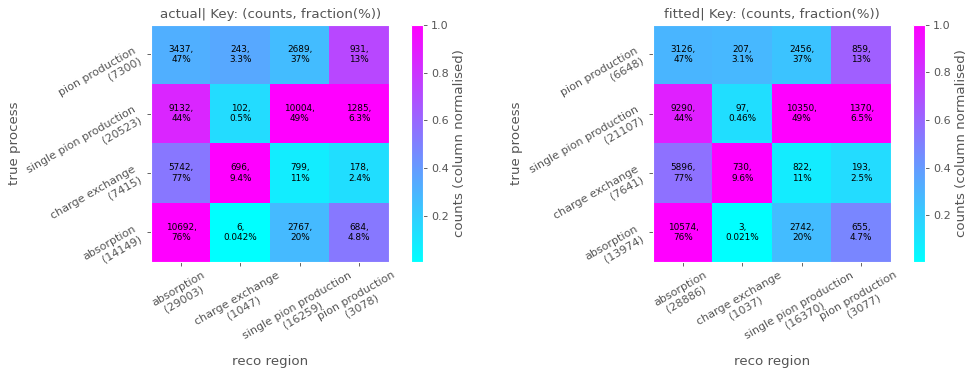

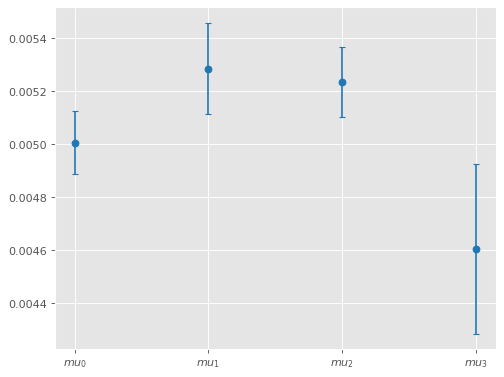

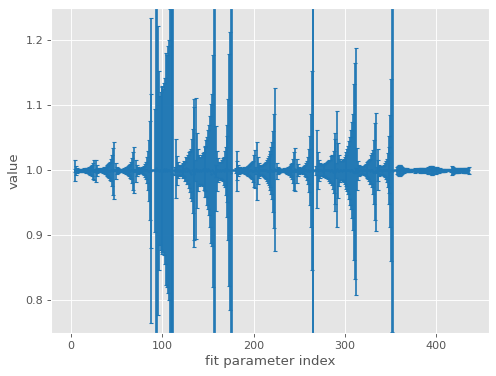

In [11]:
result = RegionFitToyStudy(toy_observed, model, energy_slice, mean_track_score_bins)

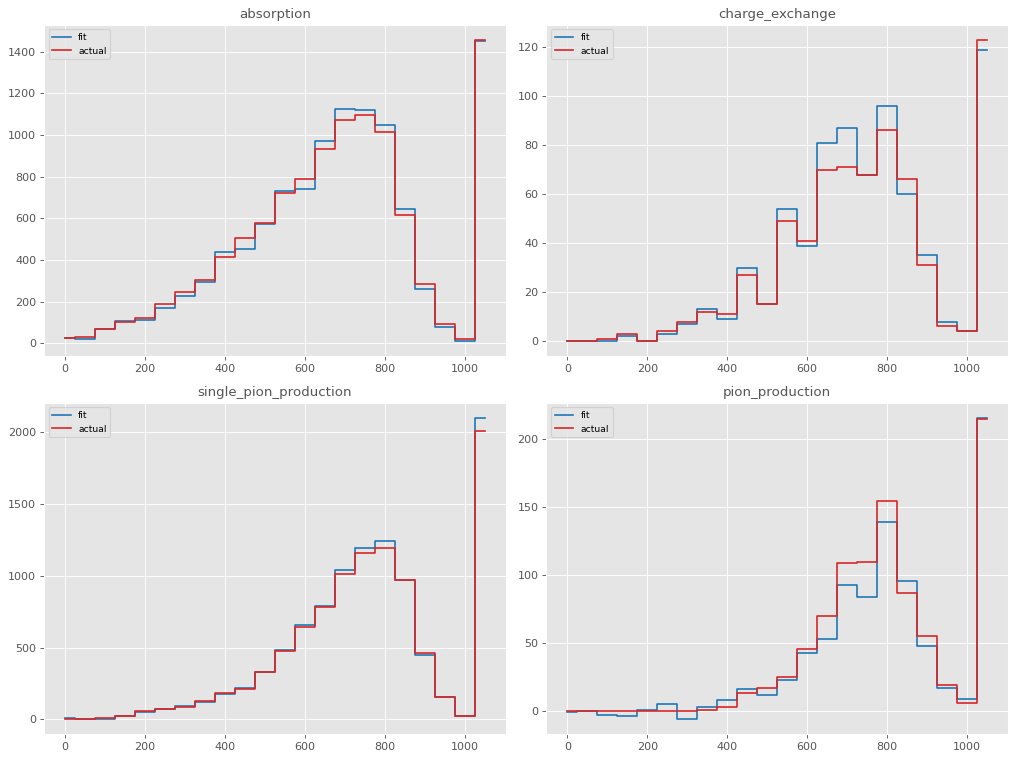

In [13]:
postfit_pred = cross_section.cabinetry.model_utils.prediction(model, fit_results = result)
KE_int_prediction = SliceModelPrediction(postfit_pred, slice(-1), "KE_int_postfit") # exclude the channel which is the mean track score

n = cross_section.RegionFit.CreateObservedInputData(cross_section.AnalysisInput.CreateAnalysisInputToy(toy_observed), energy_slice, None)

n_fit = []
for i, (n_c, lambda_c) in enumerate(zip(n, KE_int_prediction.model_yields)):
    # print(i, n_c, lambda_c)
    n_c_fit = n_c
    for j, s in enumerate(lambda_c):
        if j == i: continue
        n_c_fit = n_c_fit - s
    n_fit.append(np.array(n_c_fit.astype(int)))

actual = [cross_section.EnergySlice.CountingExperiment(
    toy_observed.df.KE_int_smeared,
    toy_observed.df.KE_init_smeared,
    (toy_observed.df.z_int_smeared < 0) | (toy_observed.df.z_int_smeared > 700),
    toy_observed.reco_regions[l] & toy_observed.truth_regions[l],
    energy_slice)[2] for l in toy_observed.truth_region_labels]

# n_fit_template = [KE_int_prediction.model_yields[i][i] for i in range(len(KE_int_prediction.model_yields))]

energy_bins = np.sort(np.insert(energy_slice.pos, 0, energy_slice.max_pos + energy_slice.width))
for i in Plots.MultiPlot(len(n_fit)):
    Plots.Plot(energy_bins[::-1], n_fit[i], label = "fit", color = "C0", marker = "x", newFigure = False, style = "step")
    Plots.Plot(energy_bins[::-1], actual[i], label = "actual", color = "C6", marker = "x", title = toy_observed.truth_region_labels[i], newFigure = False, style = "step")

['absorption', 'charge_exchange', 'single_pion_production', 'pion_production']

signal: charge_exchange

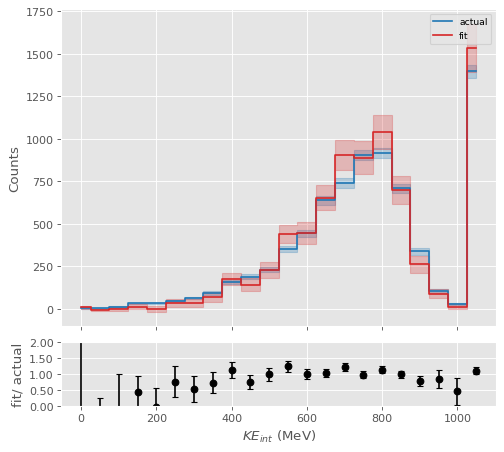

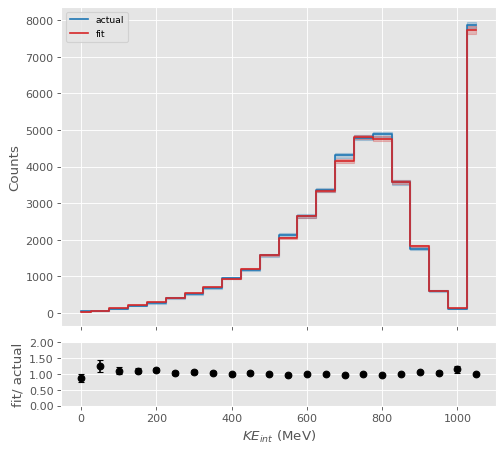

In [40]:
def PlotPrefitPostFit(prefit, prefit_err, postfit, postfit_err):
    with Plots.RatioPlot(energy_bins[::-1], postfit, prefit, postfit_err, prefit_err, "$KE_{int}$ (MeV)", "fit/ actual") as ratio_plot:
        Plots.Plot(ratio_plot.x, ratio_plot.y2, yerr = ratio_plot.y2_err, color = "C0", label = "actual", style = "step", newFigure = False)
        Plots.Plot(ratio_plot.x, ratio_plot.y1, yerr = ratio_plot.y1_err, color = "C6", label = "fit", style = "step", ylabel = "Counts", newFigure = False)

print(toy_input.truth_region_labels)
process = "charge_exchange"
print(f"signal: {process}")

N = sum(n)
# print(f"{N=}")

L = np.sum(KE_int_prediction.model_yields, 0)
# print(f"{L=}")

L_err = KE_int_prediction.total_stdev_model_bins[:, :-1] # last entry in the array is the total error for the whole channel (but we want the total error in each process)
L_err = np.sqrt(np.sum(L_err **2, 0)) # quadrature sum across all bins
# print(L_err)

L_var_bkg = sum(L_err[process != np.array(toy_input.truth_region_labels)]**2)
L_bkg = sum(L[process != np.array(toy_input.truth_region_labels)])

# print(f"{L_bkg=}")
# print(f"{L_var_bkg=}")

KE_int_fit = N - L_bkg
KE_int_fit_err = np.sqrt(N + L_var_bkg)

# print(f"{KE_int_fit=}")
# print(f"{KE_int_fit_err=}")

analysis_input = cross_section.AnalysisInput.CreateAnalysisInputToy(toy_observed)

actual = {l :  analysis_input.NInteract(energy_slice, analysis_input.exclusive_process[l]) for l in toy_observed.truth_region_labels}
actual_sig = actual[process]
actual_bkg = sum(np.array(list(actual.values()))[process != np.array(toy_input.truth_region_labels)])

# print(f"{actual_sig=}")
# print(f"{actual_bkg=}")

PlotPrefitPostFit(actual_sig, np.sqrt(actual_sig), KE_int_fit, KE_int_fit_err)
PlotPrefitPostFit(actual_bkg, np.sqrt(actual_bkg), L_bkg, np.sqrt(L_var_bkg))

xs_reco_fit_err=array([ 23.66636638,  17.82111865,  12.13622978,   9.59971871,
         8.62913627,   8.50574248,   8.85760466,   9.55265538,
        10.43694225,  11.59320554,  13.28769589,  14.86583797,
        16.88718608,  19.44164011,  23.03958721,  27.98394912,
        35.29228867,  46.44227161,  63.60952502, 129.57968623,
         0.        ,          nan])

(0.0, 327.91921254952456)

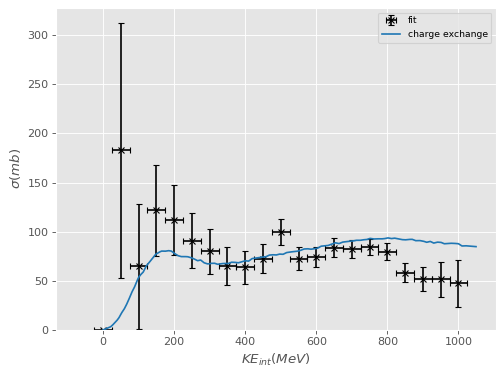

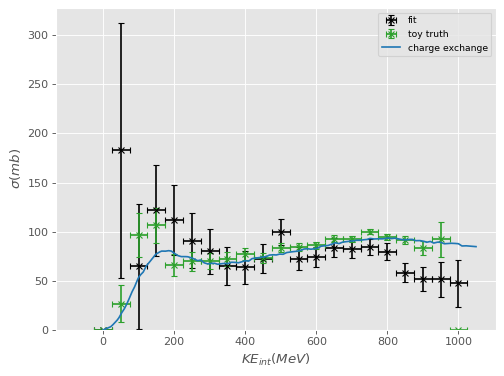

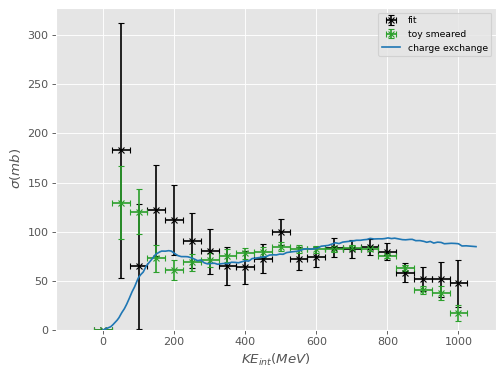

In [32]:
def XSToy(toy : cross_section.Toy, slice_dEdX : np.array, smeared : bool = False):
    KE_int = toy.df.KE_int if smeared is False else toy.df.KE_int_smeared
    KE_init = toy.df.KE_init if smeared is False else toy.df.KE_init_smeared
    outside_tpc = toy.outside_tpc if smeared is False else toy.outside_tpc_smeared

    _, n_interact_inelastic,n_interact_exclusive, n_incident = cross_section.EnergySlice.CountingExperiment(KE_int, KE_init, outside_tpc, toy.truth_regions[process], energy_slice)

    # n_int_inc, n_inc_inc = cross_section.EnergySlice.CountingExperiment(KE_int, KE_init, outside_tpc, toy.df.inclusive_process != "decay", energy_slice)
    # n_int_ex = cross_section.EnergySlice.CountingExperiment(KE_int, KE_init, outside_tpc, toy.truth_regions[process], energy_slice, interact_only = True)
    xs = cross_section.EnergySlice.CrossSection(n_interact_exclusive[1:], n_interact_inelastic[1:], n_incident[1:], slice_dEdX[1:], energy_slice.width)
    output = {"n_interact_exclusive" : n_interact_exclusive, "n_interact_inclusive" : n_interact_inelastic, "n_incident_inclusive" : n_incident, "xs" : xs[0], "xs_err" : xs[1]}
    return output


geant_xs = cross_section.GeantCrossSections(energy_range = energy_range)
slice_dEdX = cross_section.EnergySlice.Slice_dEdX(energy_slice, cross_section.Particle.from_pdgid(211))

xs_true = XSToy(toy_observed, slice_dEdX, False)
xs_reco = XSToy(toy_observed, slice_dEdX, True) # smeared

xs_reco_fit = cross_section.EnergySlice.CrossSection(np.where(KE_int_fit < 0, 0, KE_int_fit)[1:], xs_reco["n_interact_inclusive"][1:], xs_reco["n_incident_inclusive"][1:], slice_dEdX[1:], energy_slice.width)

# xs_reco_fit_err = np.sqrt(np.array(xs_reco_fit[1]**2 + (KE_int_fit_err * xs_reco_fit[0] / KE_int_fit)**2, dtype = float))
xs_reco_fit_err = np.array(KE_int_fit_err[1:] * xs_reco_fit[0] / KE_int_fit[1:], dtype = float) # fit error accounts for statistical uncertainty as well

print(f"{xs_reco_fit_err=}")

x = energy_slice.pos[1:]

# Plots.Plot(x, xs_reco_fit[0][:-1], xerr = energy_slice.width/2, yerr = xs_reco_fit[1][:-1], linestyle = "", marker = "x", color = "black", label = "fit", newFigure = False)
Plots.Plot(x, xs_reco_fit[0], xerr = energy_slice.width/2, yerr = xs_reco_fit_err, linestyle = "", marker = "x", color = "black", label = "fit")
geant_xs.Plot(process)
plt.ylim(0)

Plots.Plot(x, xs_reco_fit[0], xerr = energy_slice.width/2, yerr = xs_reco_fit_err, linestyle = "", marker = "x", color = "black", label = "fit")
Plots.Plot(x, xs_true["xs"], xerr = energy_slice.width/2, yerr = xs_true["xs_err"], linestyle = "", marker = "x", color = "C4", label = "toy truth", newFigure = False)
geant_xs.Plot(process)
plt.ylim(0)

Plots.Plot(x, xs_reco_fit[0], xerr = energy_slice.width/2, yerr = xs_reco_fit_err, linestyle = "", marker = "x", color = "black", label = "fit")
Plots.Plot(x, xs_reco["xs"], xerr = energy_slice.width/2, yerr = xs_reco["xs_err"], linestyle = "", marker = "x", color = "C4", label = "toy smeared", newFigure = False)
geant_xs.Plot(process)
plt.ylim(0)

In [31]:
def weighted_chi_sqr(observed, expected, uncertainties):
    return np.nansum((observed - expected)**2 / uncertainties**2) / len(observed)

sim_curve_interp = cex_toy_generator.interp1d(geant_xs.KE, getattr(geant_xs, process), fill_value = "extrapolate")(x)
weighted_chi_sqrs = {
    "truth": weighted_chi_sqr(xs_true["xs"][:-2], sim_curve_interp, xs_true["xs_err"][:-2]),
    "smeared": weighted_chi_sqr(xs_reco["xs"][:-2], sim_curve_interp, xs_reco["xs_err"][:-2]),
    "fit": weighted_chi_sqr(xs_reco_fit[0][:-1], sim_curve_interp, xs_reco_fit[1][:-1])
}
print(weighted_chi_sqrs)

{'truth': 1.2834386713268517, 'smeared': 20.436367137343048, 'fit': 33.475855250784946}

# ABCD Method

In [ ]:
def ABCDModel(samples : np.array):
    channels = [
        {
            "name": f"channel_0",
            "samples":[
                {
                    "name" : f"sig_A",
                    "data" : samples[0][0].tolist(),
                    "modifiers" : [
                        {'name': f"mu_sig", 'type': 'normfactor', 'data': None},
                        {'name': f"pois_err_sig_A", 'type': 'shapesys', 'data': np.sqrt(samples[0][0]).astype(int).tolist()}
                        ]
                },
                {
                    "name" : f"bkg_A",
                    "data" : samples[0][1].tolist(),
                    "modifiers" : [
                        {'name': f"mu_bkg", 'type': 'normfactor', 'data': None},
                        {'name': f"pois_err_bkg_A", 'type': 'shapesys', 'data': np.sqrt(samples[0][1]).astype(int).tolist()}
                        ]
                },

            ]
        },
        {
            "name": f"channel_1",
            "samples":[
                {
                    "name" : f"sig_B",
                    "data" : samples[1][0].tolist(),
                    "modifiers" : [
                        {'name': f"mu_sig", 'type': 'normfactor', 'data': None},
                        {'name': f"pois_err_sig_B", 'type': 'shapesys', 'data': np.sqrt(samples[1][0]).astype(int).tolist()}
                        ]
                },
                {
                    "name" : f"bkg_B",
                    "data" : samples[1][1].tolist(),
                    "modifiers" : [
                        {'name': f"alpha", 'type': 'normfactor', 'data': None},
                        {'name': f"mu_bkg", 'type': 'normfactor', 'data': None},
                        {'name': f"pois_err_bkg_B", 'type': 'shapesys', 'data': np.sqrt(samples[1][1]).astype(int).tolist()}
                        ]
                }
            ]
        },
        {
            "name": f"channel_2",
            "samples":[
                {
                    "name" : f"sig_C",
                    "data" : samples[2][0].tolist(),
                    "modifiers" : [
                        {'name': f"mu_sig", 'type': 'normfactor', 'data': None},
                        {'name': f"pois_err_sig_C", 'type': 'shapesys', 'data': np.sqrt(samples[2][0]).astype(int).tolist()}
                        ]
                },
                {
                    "name" : f"bkg_C",
                    "data" : samples[2][1].tolist(),
                    "modifiers" : [
                        {'name': f"beta", 'type': 'normfactor', 'data': None},
                        {'name': f"mu_bkg", 'type': 'normfactor', 'data': None},
                        {'name': f"pois_err_bkg_C", 'type': 'shapesys', 'data': np.sqrt(samples[2][1]).astype(int).tolist()}
                        ]
                }
            ]
        },
        {
            "name": f"channel_3",
            "samples":[
                {
                    "name" : f"sig_D",
                    "data" : samples[3][0].tolist(),
                    "modifiers" : [
                        {'name': f"mu_sig", 'type': 'normfactor', 'data': None},
                        {'name': f"pois_err_sig_D", 'type': 'shapesys', 'data': np.sqrt(samples[3][0]).astype(int).tolist()}
                        ]
                },
                {
                    "name" : f"bkg_D",
                    "data" : samples[3][1].tolist(),
                    "modifiers" : [
                        {'name': f"alpha", 'type': 'normfactor', 'data': None},
                        {'name': f"beta", 'type': 'normfactor', 'data': None},
                        {'name': f"mu_bkg", 'type': 'normfactor', 'data': None},
                        {'name': f"pois_err_bkg_D", 'type': 'shapesys', 'data': np.sqrt(samples[3][1]).astype(int).tolist()}
                        ]
                }
            ]
        },
    ]
    spec = {"channels" : channels}
    model = cross_section.pyhf.Model(spec, poi_name = "mu_sig")
    return model

def CreateModelInputDataABCD(toy : cross_section.Toy, signal : str, bins : np.array):
    samples_binned = []
    for r in toy.reco_regions:
        samples = []
        for t in toy.truth_regions:
            if t == "charge_exchange":
                samples.append(np.histogram(toy.df.KE_int_smeared[toy.reco_regions[r] & toy.truth_regions[t]], bins)[0])
                samples.append(np.histogram(toy.df.KE_int_smeared[toy.reco_regions[r] & ~toy.truth_regions[t]], bins)[0])
        samples_binned.append(samples)
    return samples_binned


def CreateObservedInputData(toy : cross_section.Toy, energy_bins : np.array, alt_regions : pd.DataFrame = None):
    toy_observed_binned = []

    reco_regions = toy.df.filter(regex = "reco_regions") if alt_regions is None else alt_regions.columns 

    for c in reco_regions:
        m = toy.df[c] if alt_regions is None else alt_regions[c]
        toy_observed_binned.append(np.histogram(toy.df.KE_int_smeared[m], bins = energy_bins)[0])
    if mean_track_score_bins is not None:
        toy_observed_binned.append(np.histogram(toy.df.mean_track_score[toy.df.inclusive_process != "decay"], mean_track_score_bins)[0])
    return toy_observed_binned


def ABCD_MLEScan(toy, model, bins, poi_ind : int, params : np.array):
    observations = cross_section.RegionFit.GenerateObservations(CreateObservedInputData(toy, bins, toy.reco_regions), model)
    # params = np.array(params)
    p = np.linspace(0, 2, 101)
    nll = []
    for i in p:
        params_new = np.array(params)
        params_new[poi_ind] = i
        nll.append(-2 * model.logpdf(params_new, observations)[0])

    Plots.Plot(p, nll, xlabel = model.config.par_names[poi_ind], ylabel = "$-2\ln(L)$", newFigure = False)
    min_ind = np.argmin(nll)
    Plots.Plot(p[min_ind], nll[min_ind], marker = "x", newFigure = False, label = f"minimum | {model.config.par_names[poi_ind]}={p[min_ind]:.3g}, $-2\ln(L)$={nll[min_ind]:.3g}", color = "black")


def ABCD_Study(toy_model : cross_section.Toy, toy_obs : cross_section.Toy, pdf : Plots.PlotBook):
    bins = np.linspace(0, 1050, 22)
    model_alt = ABCDModel(CreateModelInputDataABCD(toy_model, bins))
    observed = cross_section.RegionFit.GenerateObservations(CreateObservedInputData(toy_obs, bins, toy_obs.reco_regions), model_alt)
    result = cross_section.RegionFit.Fit(observed, model_alt, False)

    prefit_pred = cross_section.cabinetry.model_utils.prediction(model_alt)
    postfit_pred = cross_section.cabinetry.model_utils.prediction(model_alt, fit_results = result)
    print(result)

    true_counts = cross_section.Toy.ComputeCounts(toy_obs.truth_regions, toy_obs.reco_regions)
    cex_toy_parameters.PlotCorrelationMatrix(true_counts, toy_obs.truth_region_labels, toy_obs.reco_region_labels)
    pdf.Save()

    titles = toy_model.reco_region_labels

    x = (bins[1:] + bins[:-1]) / 2
    for n, (i, j) in Plots.IterMultiPlot(list(zip(prefit_pred.model_yields, postfit_pred.model_yields))):
        Plots.Plot(x, i[4 + n], label = "prefit signal", xlabel = "smeared $KE_{int}$(MeV)", title = titles[n].replace("_", " "), newFigure = False)
        Plots.Plot(x, i[n], label = "prefit bkg", newFigure = False)

        Plots.Plot(x, j[4 + n], label = "postfit signal", newFigure = False)
        Plots.Plot(x, j[n], label = "postfit bkg", newFigure = False)
    pdf.Save()

    actual_yield = CreateModelInputDataABCD(toy_obs, bins)
    for n, (i, j, k) in Plots.IterMultiPlot(list(zip(actual_yield, postfit_pred.model_yields, postfit_pred.total_stdev_model_bins))):
        Plots.Plot(x, i[0], label = "actual signal", xlabel = "smeared $KE_{int}$(MeV)", title = titles[n], newFigure = False)
        Plots.Plot(x, i[1], label = "actual bkg", newFigure = False)

        Plots.Plot(x, j[4 + n], yerr = k[4 + n], label = "postfit signal", newFigure = False)
        Plots.Plot(x, j[n], yerr = k[n], label = "postfit bkg", newFigure = False)
    pdf.Save()

    for i in Plots.MultiPlot(4):
        ABCD_MLEScan(toy_obs, model_alt, bins, i, model_alt.config.suggested_init())
    pdf.Save()
    return

In [ ]:
pdf_valid = Plots.PlotBook("toy_ABCD_valid.pdf", True)
ABCD_Study(toy_input, toy_input, pdf_valid)
pdf_valid.close()

In [ ]:
pdf_vary = Plots.PlotBook("toy_ABCD_vary_regions.pdf", True)
ABCD_Study(toy_input, toy_alt, pdf_vary)
pdf_vary.close()